In [532]:
### Run MOFA model (20 Factors; all variables) on pre-processed data and evaluate results
### generate MOFA plots of manuscripts

#############################################
# Prerequisites - Load Libraries

In [533]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"


Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dfidx’:

    select


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:genefilter’:

    area


The following object is masked from ‘package:rstatix’:

    select


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:plotly’:

    select


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




In [534]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [4]:
data_path = '../data/current'

In [5]:
result_path = '../results/current'

In [6]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Functions

In [7]:
### Function for quantile normalization

quantile_normalization = function(X){
  set.seed(42)
  ranks = apply(X, 2, rank, ties.method = 'min')  # determine ranks of each entry
  
  sorted = data.frame(apply(X, 2, sort)) # sort the entries
  means = apply(sorted, 1, mean) # calculate the means
  
  normalized_data = apply(ranks, 2 ,function(x){ means[x]}) # substitute the means into ranks matrix
}


In [8]:
### Gene wise quantile normalization

stdnorm <- function(x) {
  set.seed(42)
  r = rank(x[!is.na(x)], ties.method="average")
  x[!is.na(x)] = qnorm(r / (length(x[!is.na(x)]) + 1))
  return(x)
}

In [9]:
### Function to calculate mean difference between two groups

t_test_for_groups = function(heatmap_data, group1 = 'TP1|TP2', group2 = 'TP3|TP4', variable = 'measurement'){
    heatmap_data$group = NA
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group1))] = 'group1'
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group2))] = 'group2'
    
    t_test_result = heatmap_data %>% group_by(variable,view) %>% t_test(value~group)
    heatmap_data = merge(heatmap_data,t_test_result[,c('variable', 'view', 'p')])
    heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    return(heatmap_data)
    }

# Load Data 

## Prepared combined data

In [10]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:26:41 CET"


In [11]:
data_long$X = NULL

## Sample Data

In [12]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [13]:
sample_data$CK_raw = sample_data$CK

In [14]:
sample_data$CK = log2(sample_data$CK+1)

In [15]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [16]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [17]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [18]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [19]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [20]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Nichenet data (for specifying ligands)

In [21]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [22]:
### Generate data in long format

In [23]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [24]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [25]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [26]:
ligands = unique(ligand_target_matrix_long$ligand)

In [27]:
head(ligands)

[1] CXCL1 CXCL2 CXCL3 CXCL5 PPBP  CXCL6
688 Levels: CXCL1 CXCL2 CXCL3 CXCL5 PPBP CXCL6 CXCL8 CXCL9 CXCL10 ... PCDHA12

# Train MOFA Model

In [28]:
length(unique(data_long$variable))

[1] 13282

## Prepare data list

In [29]:
length(unique(data_long$sample_id))

[1] 128

In [30]:
final_data_long_backup = data_long

In [31]:
final_data_long = final_data_long_backup

In [32]:
final_data_long$cell_type = NULL

In [33]:
final_data_long$variable_transformed = NULL

In [34]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [35]:
final_data_long$config = NULL

In [36]:
final_data_long$X = NULL

In [37]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [38]:
samples = unique(final_data_long$sample_id)

In [39]:
### Prepare data list for MOFA

In [40]:
data_list = list()

In [41]:
nrow(final_data_long)

[1] 1700096

In [42]:
data_list= list()

In [43]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

In [44]:
dim(data)

[1] 872 128

In [45]:
#str(data_list)

## Create MOFA object

### Create for own data and train

In [46]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [47]:
data_list_orig = data_list

In [48]:
## Adjustments for plotting overview

In [49]:
names(data_list) = str_replace(names(data_list), 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
names(data_list) = str_replace(names(data_list), 'clinical_data', 'Clinical')
names(data_list) = str_replace(names(data_list), 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
names(data_list) = str_replace(names(data_list), 'X10_Bcell', 'B cells (Cluster 10)')
names(data_list) = str_replace(names(data_list), 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
names(data_list) = str_replace(names(data_list), 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
names(data_list) = str_replace(names(data_list), 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
names(data_list) = str_replace(names(data_list), 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
names(data_list) = str_replace(names(data_list), 'X3_NK', 'NK cells (Cluster 3)')
names(data_list) = str_replace(names(data_list), 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
names(data_list) = str_replace(names(data_list), 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
names(data_list) = str_replace(names(data_list), 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
names(data_list) = str_replace(names(data_list), 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
names(data_list) = str_replace(names(data_list), 'X8_Bcell','B cells (Cluster 8)')
names(data_list) = str_replace(names(data_list), 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


names(data_list) = str_replace(names(data_list), 'clinical','Clinical')
names(data_list) = str_replace(names(data_list), 'cytokine','Cytokine')
names(data_list) = str_replace(names(data_list), 'neutrophil','Neutrophil')
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [50]:
names(data_list)

[1] "Clinical"                            "Cytokine"                           
 [3] "Neutrophil"                          "Proteomics"                         
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [51]:
#str(data_list)

In [52]:

MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [53]:
### Plot Data Overview

In [54]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

In [55]:
length(unique(data_long$variable))

[1] 13282

In [56]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [57]:
figure_name = "SUPP1_MOFA_Feature_Overview"

In [58]:
# Sizes of the plot
width_par = 8.07
height_par =6

In [59]:
mofa_overview = mofa_overview + plot_config +cell_type_colors+
                xlabel + ylabel + theme(axis.text.x = element_blank())

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


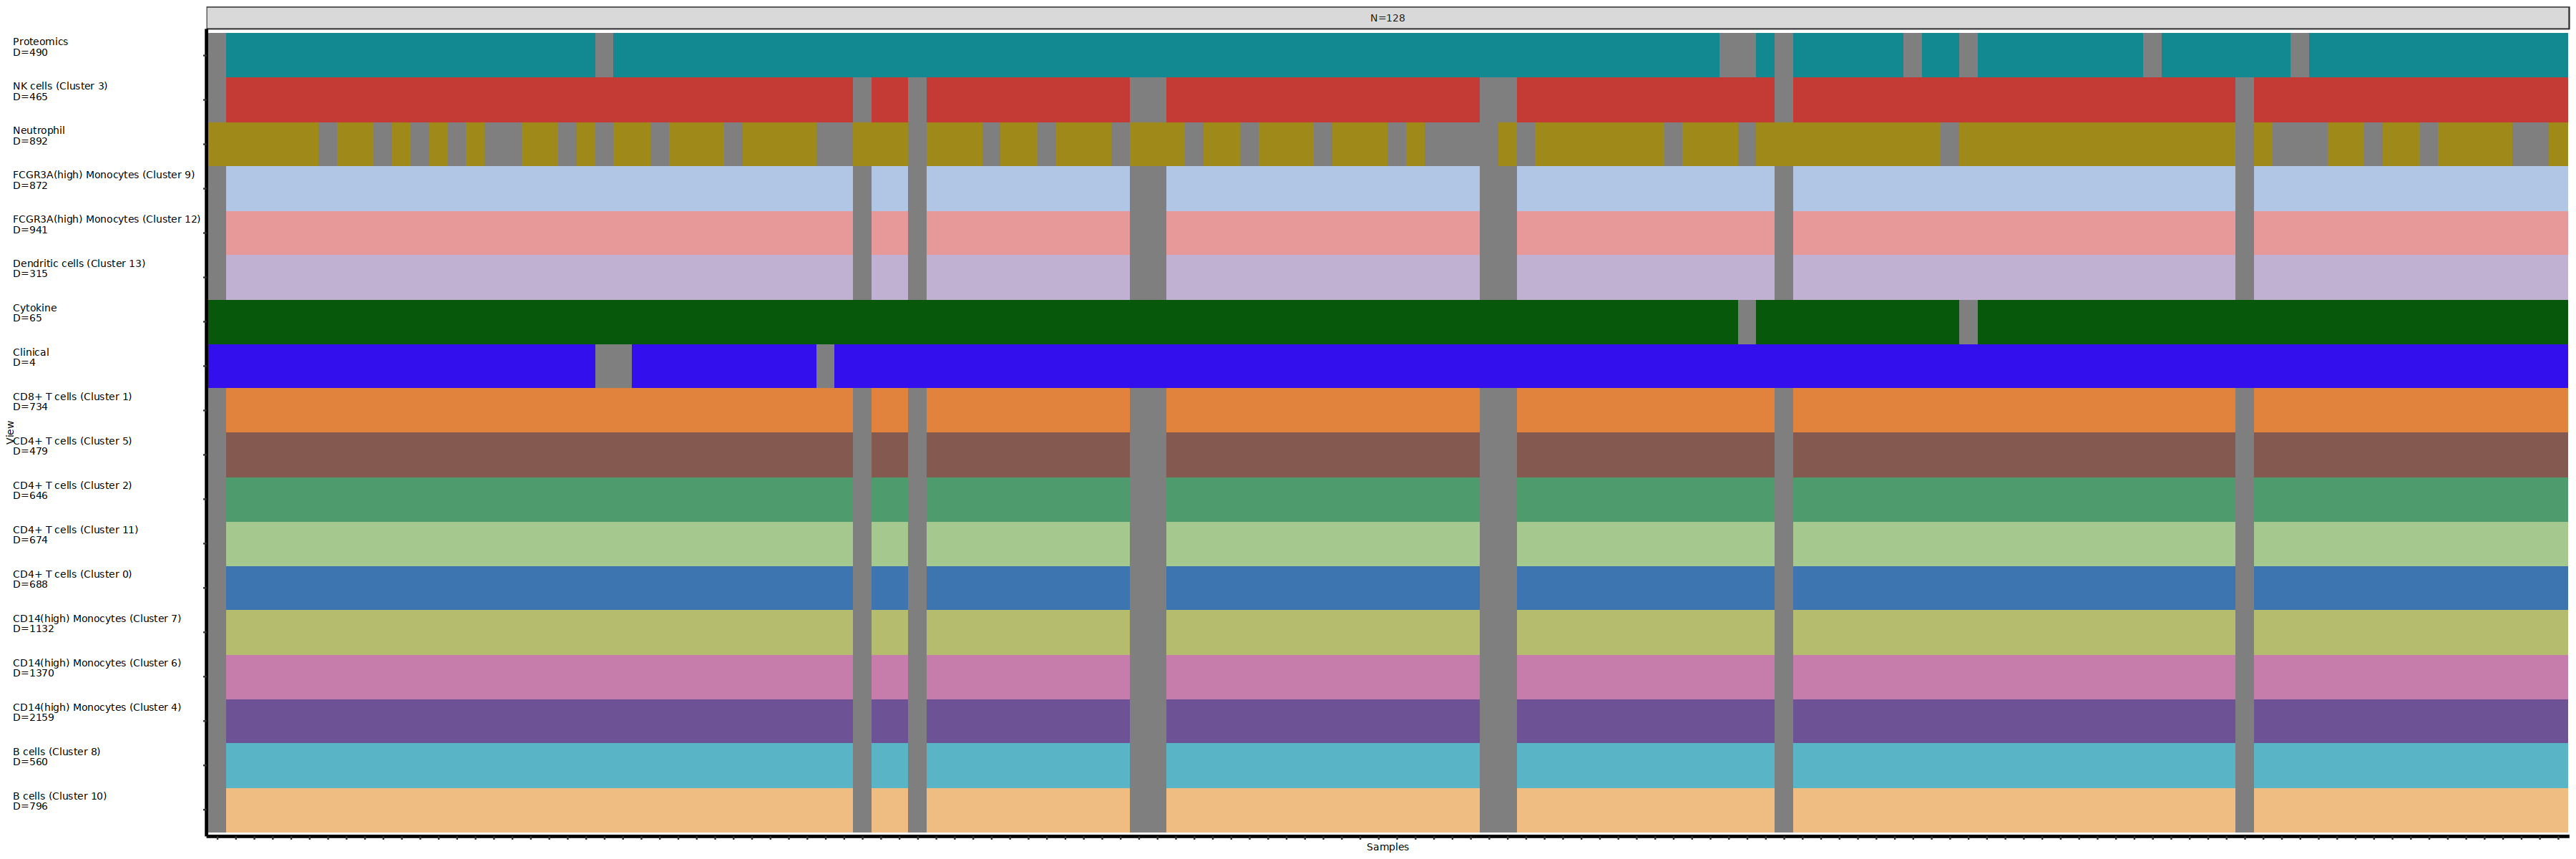

In [60]:
mofa_overview

In [61]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,'_', name,'.pdf'), width =width_par, height = height_par)
print(mofa_overview)
dev.off()

png 
  2

In [62]:
### Use orig MOFA object

In [63]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




###  Add covariates for mefisto

In [64]:
MOFAobject

Untrained MOFA model with the following characteristics: 
 Number of views: 18 
 Views names: clinical_data cytokine neutrophil proteomics X0_TcellCD4 X1_TcellCD8 X10_Bcell X11_TcellCD4 X12_MonocytesCD16_FCGR3A X13_Dendritic X2_TcellCD4 X3_NK X4_MonocytesCD14 X5_TcellCD4 X6_MonocytesCD14 X7_MonocytesCD14 X8_Bcell X9_MonocytesCD16_FCGR3A 
 Number of features (per view): 4 65 892 490 688 734 796 674 941 315 646 465 2159 479 1370 1132 560 872 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 128 
 

In [65]:
#cov = as.data.frame(cov)

### Set data options

In [66]:
mefisto_opts = get_default_mefisto_options(MOFAobject)

In [67]:
data_opts = get_default_data_options(MOFAobject)

In [68]:
data_opts

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "clinical_data"            "cytokine"                
 [3] "neutrophil"               "proteomics"              
 [5] "X0_TcellCD4"              "X1_TcellCD8"             
 [7] "X10_Bcell"                "X11_TcellCD4"            
 [9] "X12_MonocytesCD16_FCGR3A" "X13_Dendritic"           
[11] "X2_TcellCD4"              "X3_NK"                   
[13] "X4_MonocytesCD14"         "X5_TcellCD4"             
[15] "X6_MonocytesCD14"         "X7_MonocytesCD14"        
[17] "X8_Bcell"                 "X9_MonocytesCD16_FCGR3A" 

$groups
[1] "group1"

In [69]:
data_opts$scale_views = TRUE # decide whether to scale the data

In [70]:
## Define model options

In [71]:
model_opts = get_default_model_options(MOFAobject)
model_opts

$likelihoods
           clinical_data                 cytokine               neutrophil 
              "gaussian"               "gaussian"               "gaussian" 
              proteomics              X0_TcellCD4              X1_TcellCD8 
              "gaussian"               "gaussian"               "gaussian" 
               X10_Bcell             X11_TcellCD4 X12_MonocytesCD16_FCGR3A 
              "gaussian"               "gaussian"               "gaussian" 
           X13_Dendritic              X2_TcellCD4                    X3_NK 
              "gaussian"               "gaussian"               "gaussian" 
        X4_MonocytesCD14              X5_TcellCD4         X6_MonocytesCD14 
              "gaussian"               "gaussian"               "gaussian" 
        X7_MonocytesCD14                 X8_Bcell  X9_MonocytesCD16_FCGR3A 
              "gaussian"               "gaussian"               "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [72]:
model_opts$num_factors = 20 # define number of factors

In [73]:
#model_opts$likelihoods

### Define training options

In [74]:
train_opts  = get_default_training_options(MOFAobject)
train_opts

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$seed
[1] 42

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE

In [75]:
train_opts$maxiter = 50000

In [76]:
train_opts$verbose = TRUE

In [77]:
train_opts$seed = 42

In [78]:
train_opts$weight_views = FALSE

### Stochastic Options

In [79]:
stoch_options = get_default_stochastic_options(MOFAobject)

In [80]:
stoch_options

$batch_size
[1] 0.5

$learning_rate
[1] 1

$forgetting_rate
[1] 0.5

$start_stochastic
[1] 1

### Build and train the model

In [81]:
MOFAobject = prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  mefisto_options = mefisto_opts,
  training_options = train_opts #,
  #stochastic_options = stoch_options
)

Warning message in prepare_mofa(object = MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



### Save the model

In [82]:
#name = 'V26'

In [83]:
train_opts$weight_views

[1] FALSE

In [84]:
name

[1] "V_FINAL_INTEGRATED"

In [85]:
model_name = paste0("MOFA_MODEL", name, '-', train_opts$weight_views,'.hdf5')

In [86]:
model_name

[1] "MOFA_MODELV_FINAL_INTEGRATED-FALSE.hdf5"

In [87]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [92]:
MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [93]:
nrow(sample_data)

[1] 149

In [94]:
length(unique(sample_data$sample_id))

[1] 149

In [95]:
model <- load_model(outfile, verbose = TRUE)

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”
Checking for highly correlated factors...



In [96]:
length(unique(data_long$variable))

[1] 13282

# Downstream Analysis of generated model

In [97]:
#str(model)

In [98]:
#model = MOFAobject.trained

In [99]:
model@dimensions$D

clinical_data                 cytokine               neutrophil 
                       4                       65                      892 
              proteomics              X0_TcellCD4              X1_TcellCD8 
                     490                      688                      734 
               X10_Bcell             X11_TcellCD4 X12_MonocytesCD16_FCGR3A 
                     796                      674                      941 
           X13_Dendritic              X2_TcellCD4                    X3_NK 
                     315                      646                      465 
        X4_MonocytesCD14              X5_TcellCD4         X6_MonocytesCD14 
                    2159                      479                     1370 
        X7_MonocytesCD14                 X8_Bcell  X9_MonocytesCD16_FCGR3A 
                    1132                      560                      872

In [100]:
sum(model@dimensions$D)

[1] 13282

## Add metadata to model

In [101]:
head(model@samples_metadata, n=3)

,group,sample
,<fct>,<chr>
1,group1,k1
2,group1,k10
3,group1,k11


In [102]:
nrow(sample_data)

[1] 149

In [103]:
length(unique(sample_data$sample_id))

[1] 149

In [104]:
#head( sample_data)

In [105]:
model@samples_metadata = merge(model@samples_metadata, sample_data, by.x = 'sample', by.y = 'sample_id')

In [106]:
nrow(model@samples_metadata)

[1] 128

## Investigate Variance decomposition

In [107]:
# Total variance explained per view and group

In [108]:
model@cache[["variance_explained"]]$r2_total

$group1
           clinical_data                 cytokine               neutrophil 
                58.68897                 22.89624                 19.16477 
              proteomics              X0_TcellCD4              X1_TcellCD8 
                13.75504                 49.75254                 48.65252 
               X10_Bcell             X11_TcellCD4 X12_MonocytesCD16_FCGR3A 
                28.24749                 23.65592                 34.12398 
           X13_Dendritic              X2_TcellCD4                    X3_NK 
                30.07635                 45.04042                 42.39762 
        X4_MonocytesCD14              X5_TcellCD4         X6_MonocytesCD14 
                50.16263                 33.04643                 40.66151 
        X7_MonocytesCD14                 X8_Bcell  X9_MonocytesCD16_FCGR3A 
                36.00368                 32.88765                 34.21778

In [109]:
rowMeans(model@cache$variance_explained$r2_per_factor[[1]])

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7   Factor8 
5.5743835 5.2584826 3.3112781 2.8661250 2.3760972 1.6722643 1.5898006 1.5646010 
  Factor9  Factor10  Factor11  Factor12  Factor13  Factor14  Factor15  Factor16 
1.2735130 1.1546082 1.0721934 1.0530277 1.0358204 1.0147484 0.9824680 0.9817530 
 Factor17  Factor18  Factor19  Factor20 
0.9598309 0.9562707 0.8342284 0.7145555

In [110]:
#model@cache[["variance_explained"]]

In [111]:
mean(model@cache$variance_explained$r2_total[[1]])

[1] 35.7462

In [112]:
mean(colSums(model@cache$variance_explained$r2_per_factor[[1]]))

[1] 36.24605

In [113]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:18(1d)] 58.7 22.9 19.2 13.8 49.8 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:18] "clinical_data" "cytokine" "neutrophil" "proteomics" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:18] 4.11 19.32 4.4 10.01 9.34 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:18] "clinical_data" "cytokine" "neutrophil" "proteomics" ...


In [114]:
model@cache$variance_explained$r2_total

$group1
           clinical_data                 cytokine               neutrophil 
                58.68897                 22.89624                 19.16477 
              proteomics              X0_TcellCD4              X1_TcellCD8 
                13.75504                 49.75254                 48.65252 
               X10_Bcell             X11_TcellCD4 X12_MonocytesCD16_FCGR3A 
                28.24749                 23.65592                 34.12398 
           X13_Dendritic              X2_TcellCD4                    X3_NK 
                30.07635                 45.04042                 42.39762 
        X4_MonocytesCD14              X5_TcellCD4         X6_MonocytesCD14 
                50.16263                 33.04643                 40.66151 
        X7_MonocytesCD14                 X8_Bcell  X9_MonocytesCD16_FCGR3A 
                36.00368                 32.88765                 34.21778

In [115]:
# Variance explained for every factor in per view and group
model@cache$variance_explained$r2_per_factor[[1]] # group 1, can be summarized per column but not per Factor

,clinical_data,cytokine,neutrophil,proteomics,X0_TcellCD4,X1_TcellCD8,X10_Bcell,X11_TcellCD4,X12_MonocytesCD16_FCGR3A,X13_Dendritic,X2_TcellCD4,X3_NK,X4_MonocytesCD14,X5_TcellCD4,X6_MonocytesCD14,X7_MonocytesCD14,X8_Bcell,X9_MonocytesCD16_FCGR3A
Factor1,4.113069e+00,0.213769243,0.16138290,0.26557810,12.71914026,12.67440717,4.23345476,3.30778127,4.6505788,5.7177645,10.77615704,8.8822035,8.3188066,5.37507038,5.3903191,4.1716109,4.97941044,4.3884003
Factor2,1.932224e+01,2.845936632,1.05527899,1.06551805,8.12851307,7.69892270,2.21462087,3.47495070,3.4089570,3.3024311,6.32487975,6.3289135,6.6524673,5.18930761,5.5560510,5.8075660,3.00714253,3.2689930
Factor3,4.395155e+00,1.867266829,1.03106580,1.69180416,5.76178910,5.25184856,1.70661410,2.23969132,2.6493772,2.6248298,4.48701482,5.5715932,4.8095794,3.73840348,3.4679444,2.7987775,2.95982570,2.5504262
Factor4,1.001092e+01,3.101096917,0.61776449,3.05971587,3.41526584,2.94353598,1.05539962,1.75748153,1.8622354,1.9580957,3.02210183,3.6242555,2.8838087,3.07985721,2.9595172,3.0309903,1.62428084,1.5839265
Factor5,9.339056e+00,1.497184926,0.51219233,0.94446061,3.60422030,2.55137145,1.03217669,1.38426656,1.3011262,1.3955606,4.10330623,2.1062750,2.6872142,2.52167773,2.5400937,2.4582776,1.46807167,1.3232181
Factor6,1.404447e+00,1.022145937,0.17811556,1.39594505,3.79221857,3.39815000,0.72270324,1.37901963,0.8524447,1.0365611,3.43762634,2.3144517,1.8321379,2.70821627,1.0069238,0.8610523,1.90488559,0.8537134
Factor7,3.229438e+00,0.915163175,0.68024619,0.07548927,2.88692201,4.04605251,0.79663880,2.70005291,0.8025718,1.1097961,2.13033578,1.5499129,1.5262824,2.15397671,1.3424379,1.2567700,0.91491590,0.4994082
Factor8,2.481154e+00,0.766743116,0.24068268,0.82736628,0.50513013,0.59808862,0.37182009,0.18661859,1.1086437,1.4160079,1.46523088,0.4779773,6.7589019,0.34391435,5.0562071,4.1495231,0.68110366,0.7277045
Factor9,3.937397e-02,0.894717252,0.48306651,0.08219832,0.06823807,0.36533729,8.30085719,0.54087939,1.0265948,1.5586407,0.02897381,0.3781799,0.7287473,0.02749229,1.4617539,1.0726344,4.35076300,1.5147852
Factor10,4.183397e-02,0.617816226,0.53685527,0.73344854,1.63849228,1.46956883,0.78872315,0.95385462,0.9302557,0.6988883,1.67557623,1.7692151,2.6277142,1.41564251,1.0357624,1.5597296,1.31853345,0.9710373


In [116]:
### Save the variance decompositoin (Potentially as supplementary Table)

In [117]:
variant = '_'

In [118]:
write.csv(model@cache$variance_explained$r2_per_factor[[1]], paste0(result_path, '/E-Analysis/MOFA_Variance_Decomposition_',name, variant, train_opts$weight_views, '.csv'))

# Extract and prepare data for plots

## Adjust sample data columns

In [119]:
sample_data$class = sample_data$group

In [120]:
sample_data$measurement2 = sample_data$measurement

In [121]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [122]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [123]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [124]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [125]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [126]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [127]:
## Concatenate outcome with class

In [128]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [129]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

## Extract data (for potential supplementary tables)

In [130]:
### Visualization of single factors

In [131]:
#### Extract factors and evaluate based on sample-data

In [132]:
factors = get_factors(model, factors = "all")

In [133]:
factors = factors$group1

In [134]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20
k1,0.4811325,-0.2731317,1.4988169,-0.4135678,1.5052706,-0.92308998,-0.3904185,-0.1944797,0.16486799,-0.5581300,-0.05226468,1.3718758,0.1882956,-0.3082163,-0.47997108,0.3468897,0.5692611,0.416665730,-0.60204874,-0.03085489
k10,0.8920603,-0.7547770,0.3501023,-0.1524478,0.4074517,-0.04596939,0.6276925,-1.1656937,-0.05003504,-0.3380343,-0.01586095,-0.1020285,0.1199118,0.2096718,0.09246619,0.1335110,-0.0490552,-0.001722867,0.07838055,-0.03818913


In [135]:
factors = as.data.frame(factors)

In [136]:
factors$sample_id = rownames(factors)

In [137]:
name

[1] "V_FINAL_INTEGRATED"

In [138]:
### Save Factor Data - potentially as supplementary Table

In [139]:
write.csv(factors, paste0(result_path, '/E-Analysis/Factor_Data_' , name,'_', train_opts$weight_views,  '.csv'), row.names = FALSE)

In [140]:
weights = get_weights(model, views = "all", factors = "all")

In [141]:
weight_data = data.frame()

In [142]:
names(weights)

[1] "clinical_data"            "cytokine"                
 [3] "neutrophil"               "proteomics"              
 [5] "X0_TcellCD4"              "X1_TcellCD8"             
 [7] "X10_Bcell"                "X11_TcellCD4"            
 [9] "X12_MonocytesCD16_FCGR3A" "X13_Dendritic"           
[11] "X2_TcellCD4"              "X3_NK"                   
[13] "X4_MonocytesCD14"         "X5_TcellCD4"             
[15] "X6_MonocytesCD14"         "X7_MonocytesCD14"        
[17] "X8_Bcell"                 "X9_MonocytesCD16_FCGR3A"

In [143]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [144]:
weight_data$variable_name = rownames(weight_data)

In [145]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CK,-0.13418597,0.4019222,-0.1010765,-0.002177566,-0.5093667,0.24179134,-0.03635097,0.05304519,0.0011574664,-0.012307130,⋯,-0.1604505,-0.001418618,0.1540945,0.003821864,-0.24205661,0.004092582,-0.0005618720,-0.2423944,clinical_data,CK
CK_MB,-0.06222621,0.2731985,-0.2000362,-0.076098327,-0.1439445,0.04289833,-0.71818597,0.18658970,-0.0007753517,-0.003074308,⋯,-0.6107162,0.002499494,0.3864464,-0.001090137,-0.08311704,0.009503498,-0.0003621744,0.2060158,clinical_data,CK_MB


In [146]:
name

[1] "V_FINAL_INTEGRATED"

In [147]:
#### Save weight data potentially as supplementary table

In [148]:
write.csv(weight_data, paste0(result_path, '/E-Analysis/Weight_Data_' , name, '_', train_opts$weight_views, '.csv'), row.names = FALSE)

## Merge factors and sample data

In [149]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
k1,0.4811325,-0.2731317,1.4988169,-0.4135678,1.5052706,-0.92308998,-0.3904185,-0.1944797,0.16486799,-0.5581300,⋯,1.3718758,0.1882956,-0.3082163,-0.47997108,0.3468897,0.5692611,0.416665730,-0.60204874,-0.03085489,k1
k10,0.8920603,-0.7547770,0.3501023,-0.1524478,0.4074517,-0.04596939,0.6276925,-1.1656937,-0.05003504,-0.3380343,⋯,-0.1020285,0.1199118,0.2096718,0.09246619,0.1335110,-0.0490552,-0.001722867,0.07838055,-0.03818913,k10


In [150]:
nrow(factors)

[1] 128

In [151]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [152]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [153]:
nrow(sample_data)

[1] 149

In [154]:
length(unique(sample_data$sample_id))

[1] 149

In [155]:
factors_merge = data.frame(factors)

In [156]:
factors_merge$sample_id = rownames(factors_merge)

In [157]:
merged_data = merge(factors_merge, sample_data, by.x = 'sample_id', by.y = 'sample_id')

In [158]:
length(unique(merged_data$sample_id))

[1] 128

In [159]:
nrow(merged_data)

[1] 128

In [160]:
### Prepare long format and add necessary sample columns

In [161]:
merged_data$delta_ef_value = as.character(merged_data$delta_ef_value)

In [162]:
merged_data_long = melt(merged_data)

Using sample_id, sample, measurement, library, id.y, name, read, pattern, sequence, feature_type, X, measurement_tp, sex, classification, group, delta_ef_value_group, delta_ef_value, delta_ef_value_class, class, measurement2, measurement_class, delta_ef_value_class_summarized, tp_outcome as id variables



In [163]:
merged_data_long = merged_data_long[!is.na(str_extract(merged_data_long$variable, 'Factor')),]

In [164]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"

In [165]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [166]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [167]:
unique(merged_data_long$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP1_acs_w_infection"           "TP2_acs_w_infection"          
 [7] "TP3_acs_w_infection"           "TP1_acs_w_o_infection"        
 [9] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[11] "TP4_acs_w_o_infection"         "TP4_acs_w_infection"          
[13] "TP2_acs_subacute"              "TP3_acs_subacute"             
[15] "TP4_acs_subacute"

In [168]:
merged_data_long$class_measurement = merged_data_long$group
merged_data_long$class_measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] =merged_data_long$measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] 

In [169]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

## Extract explained variance for plotting

In [170]:
data = model@cache$variance_explained$r2_per_factor[[1]]

In [171]:
total_variance = data.frame( view = rownames(model@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = model@cache[["variance_explained"]]$r2_total$group1)

In [172]:
total_variance_factor = data.frame(factor = names(rowMeans(model@cache$variance_explained$r2_per_factor[[1]])),
                                   mean_variance = rowMeans(model@cache$variance_explained$r2_per_factor[[1]]))

In [173]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,5.574384
Factor2,Factor2,5.258483


In [174]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:18(1d)] 58.7 22.9 19.2 13.8 49.8 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:18] "clinical_data" "cytokine" "neutrophil" "proteomics" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:18] 4.11 19.32 4.4 10.01 9.34 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:18] "clinical_data" "cytokine" "neutrophil" "proteomics" ...


In [175]:
head(total_variance,2)

,view,total_variance
,<chr>,<dbl>
clinical_data,clinical_data,58.68897
cytokine,cytokine,22.89624


In [176]:
data = melt(data)

In [177]:
data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')

In [178]:
head(data,2)

,Var2,Var1,value,total_variance
,<fct>,<fct>,<dbl>,<dbl>
1,clinical_data,Factor1,4.113069,58.68897
2,clinical_data,Factor2,19.322238,58.68897


In [179]:
#data = data[data$Var1 %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [180]:
data$Var2 = str_replace(data$Var2, 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
data$Var2 = str_replace(data$Var2, 'clinical_data', 'Clinical')
data$Var2 = str_replace(data$Var2, 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
data$Var2 = str_replace(data$Var2, 'X10_Bcell', 'B cells (Cluster 10)')
data$Var2 = str_replace(data$Var2, 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
data$Var2 = str_replace(data$Var2, 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
data$Var2 = str_replace(data$Var2, 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
data$Var2 = str_replace(data$Var2, 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
data$Var2 = str_replace(data$Var2, 'X3_NK', 'NK cells (Cluster 3)')
data$Var2 = str_replace(data$Var2, 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
data$Var2 = str_replace(data$Var2, 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
data$Var2 = str_replace(data$Var2, 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
data$Var2 = str_replace(data$Var2, 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
data$Var2 = str_replace(data$Var2, 'X8_Bcell','B cells (Cluster 8)')
data$Var2 = str_replace(data$Var2, 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


data$Var2 = str_replace(data$Var2, 'clinical','Clinical')
data$Var2 = str_replace(data$Var2, 'cytokine','Cytokine')
data$Var2 = str_replace(data$Var2, 'neutrophil','Neutrophil')
data$Var2 = str_replace(data$Var2, 'proteomics','Proteomics')

In [181]:
unique(data$Var2)

[1] "Clinical"                            "Cytokine"                           
 [3] "Neutrophil"                          "Proteomics"                         
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [182]:
data$Var2 = as.character(data$Var2)

In [183]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Clinical,Factor1,4.113069,58.68897
2,Clinical,Factor2,19.322238,58.68897


In [184]:
#### Save variance decomposition as supplementary table

In [185]:
data_supp = data

In [186]:
colnames(data_supp) = c('view', 'factor', 'explained_variance', 'total_explained_variance_per_view')

In [188]:
write.csv(data_supp, paste0(result_path, '/Supplementary/SUPP_E3_Variance_Decomposition.csv'), row.names = FALSE)

## Prepare weight data

In [189]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CK,-0.13418597,0.4019222,-0.1010765,-0.002177566,-0.5093667,0.24179134,-0.03635097,0.05304519,0.0011574664,-0.012307130,⋯,-0.1604505,-0.001418618,0.1540945,0.003821864,-0.24205661,0.004092582,-0.0005618720,-0.2423944,clinical_data,CK
CK_MB,-0.06222621,0.2731985,-0.2000362,-0.076098327,-0.1439445,0.04289833,-0.71818597,0.18658970,-0.0007753517,-0.003074308,⋯,-0.6107162,0.002499494,0.3864464,-0.001090137,-0.08311704,0.009503498,-0.0003621744,0.2060158,clinical_data,CK_MB


In [190]:
weight_data$gene = weight_data$variable_name

In [191]:
unique(weight_data$type)

[1] "clinical_data"            "cytokine"                
 [3] "neutrophil"               "proteomics"              
 [5] "X0_TcellCD4"              "X1_TcellCD8"             
 [7] "X10_Bcell"                "X11_TcellCD4"            
 [9] "X12_MonocytesCD16_FCGR3A" "X13_Dendritic"           
[11] "X2_TcellCD4"              "X3_NK"                   
[13] "X4_MonocytesCD14"         "X5_TcellCD4"             
[15] "X6_MonocytesCD14"         "X7_MonocytesCD14"        
[17] "X8_Bcell"                 "X9_MonocytesCD16_FCGR3A"

In [192]:
weight_data$gene = str_replace(weight_data$variable_name, '.*__', '')

In [193]:
weight_data$view = weight_data$type

In [194]:
weight_data$view[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')] = str_replace(weight_data$variable_name[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')], '__.*', '')

In [195]:
unique(weight_data$view)

[1] "clinical_data"               "cytokine"                   
 [3] "neutrophil"                  "proteomics"                 
 [5] "X0_T.cell.CD4"               "X1_T.cell.CD8"              
 [7] "X10_B.cell"                  "X11_T.cell.CD4"             
 [9] "X12_Monocytes...CD16_FCGR3A" "X13_Dendritic"              
[11] "X2_T.cell.CD4"               "X3_NK"                      
[13] "X4_Monocytes...CD14"         "X5_T.cell.CD4"              
[15] "X6_Monocytes...CD14"         "X7_Monocytes...CD14"        
[17] "X8_B.cell"                   "X9_Monocytes...CD16_FCGR3A"

In [196]:
weight_data$view = str_replace(weight_data$view, make.names('X0_T.cell.CD4'), 'CD4+ T cells (Cluster 0)')
weight_data$view = str_replace(weight_data$view, 'clinical_data', 'Clinical')
weight_data$view = str_replace(weight_data$view, 'X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
weight_data$view = str_replace(weight_data$view, 'X10_B.cell', 'B cells (Cluster 10)')
weight_data$view = str_replace(weight_data$view, 'X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
weight_data$view = str_replace(weight_data$view, 'X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
weight_data$view = str_replace(weight_data$view, 'X13_Dendritic',  'Dendritic cells (Cluster 13)')
weight_data$view = str_replace(weight_data$view, 'X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
weight_data$view = str_replace(weight_data$view, 'X3_NK', 'NK cells (Cluster 3)')
weight_data$view = str_replace(weight_data$view, 'X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
weight_data$view = str_replace(weight_data$view, 'X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
weight_data$view = str_replace(weight_data$view, 'X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
weight_data$view = str_replace(weight_data$view, 'X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
weight_data$view = str_replace(weight_data$view, 'X8_B.cell','B cells (Cluster 8)')
weight_data$view = str_replace(weight_data$view, 'X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

weight_data$view  = str_replace(weight_data$view , 'clinical','Clinical')
weight_data$view  = str_replace(weight_data$view , 'cytokine','Cytokine')
weight_data$view  = str_replace(weight_data$view , 'neutrophil','Neutrophil')
weight_data$view  = str_replace(weight_data$view , 'proteomics','Proteomics')

In [197]:
unique(weight_data$view)

[1] "Clinical"                            "Cytokine"                           
 [3] "Neutrophil"                          "Proteomics"                         
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [198]:
#weight_data$gene = str_replace(weight_data$gene, '__', '')

In [199]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name,gene,view
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
CK,-0.13418597,0.4019222,-0.1010765,-0.002177566,-0.5093667,0.24179134,-0.03635097,0.05304519,0.0011574664,-0.012307130,⋯,0.1540945,0.003821864,-0.24205661,0.004092582,-0.0005618720,-0.2423944,clinical_data,CK,CK,Clinical
CK_MB,-0.06222621,0.2731985,-0.2000362,-0.076098327,-0.1439445,0.04289833,-0.71818597,0.18658970,-0.0007753517,-0.003074308,⋯,0.3864464,-0.001090137,-0.08311704,0.009503498,-0.0003621744,0.2060158,clinical_data,CK_MB,CK_MB,Clinical


In [200]:
feature_weights_long = melt(weight_data)

Using type, variable_name, gene, view as id variables



In [201]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,CK,CK,Clinical,Factor1,-0.13418597
2,clinical_data,CK_MB,CK_MB,Clinical,Factor1,-0.06222621


In [202]:
### Save feature weights as supplementary table

In [203]:
#unique(feature_weights_long$type)

In [204]:
#unique(feature_weights_long$view)

In [205]:
feature_weights_supp = feature_weights_long
feature_weights_supp$type = NULL
colnames(feature_weights_supp) = c('feature_name', 'gene', 'view', 'factor', 'weight')

In [206]:
head(feature_weights_supp,2)

,feature_name,gene,view,factor,weight
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,CK,CK,Clinical,Factor1,-0.13418597
2,CK_MB,CK_MB,Clinical,Factor1,-0.06222621


In [207]:
write.csv(feature_weights_supp, paste0(result_path, '/Supplementary/SUPP_E3_Feature_Weights.csv'), row.names = FALSE)

In [208]:
### Factor data in long format

In [209]:
factor_data = melt(factors)

Using sample_id as id variables



In [210]:
head(factor_data,2)

,sample_id,variable,value
,<chr>,<fct>,<dbl>
1,k1,Factor1,0.4811325
2,k10,Factor1,0.8920603


In [211]:
colnames(factor_data) = c('sample_id', 'variable', 'value')

## Get top features per factor and amounts for diff thresholds

In [212]:
top_variable_fraction_list  = c(0.0005 ,0.001, 0.0025, 0.005, 0.025, 0.05, 0.1,0.5)

In [213]:
geneset_oi_amounts = data.frame()

In [214]:
geneset_oi_per_fraction = data.frame()

In [215]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,CK,CK,Clinical,Factor1,-0.13418597
2,clinical_data,CK_MB,CK_MB,Clinical,Factor1,-0.06222621


In [216]:
dimensions = unique(feature_weights_long[,c('view', 'variable')])

In [217]:
head(dimensions,2)

,view,variable
,<chr>,<fct>
1,Clinical,Factor1
5,Cytokine,Factor1


In [218]:
for(i in top_variable_fraction_list){
    ## Define amont of top genes per fraction 
    geneset_oi_pos_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(i)
    geneset_oi_pos_per_factor_analyze$direction = 'positive'
    
    geneset_oi_neg_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-i)
    geneset_oi_neg_per_factor_analyze$direction = 'negative'
    
    geneset_oi_analyze = rbind(geneset_oi_pos_per_factor_analyze, geneset_oi_neg_per_factor_analyze)
    geneset_oi_analyze$fraction = i
    
    geneset_oi_per_fraction = rbind(geneset_oi_per_fraction,geneset_oi_analyze)
    
    amount_geneset_oi_type = geneset_oi_analyze %>% group_by(type, view, variable) %>% count()
    amount_geneset_oi_type = merge(dimensions, amount_geneset_oi_type, all.x = TRUE)
    amount_geneset_oi_type$fraction = i
    
    geneset_oi_amounts = rbind(geneset_oi_amounts, amount_geneset_oi_type)
    }

Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value


In [219]:
features_per_type = feature_weights_long %>% group_by(type, view, variable) %>% count()
colnames(features_per_type) = c('type', 'view', 'variable', 'amount_features')

In [220]:
head(features_per_type,2)

type,view,variable,amount_features
<chr>,<chr>,<fct>,<int>
X0_TcellCD4,CD4+ T cells (Cluster 0),Factor1,688
X0_TcellCD4,CD4+ T cells (Cluster 0),Factor2,688


In [221]:
geneset_oi_amounts = merge(  geneset_oi_amounts,features_per_type, all.x = TRUE)
geneset_oi_amounts$percentage = geneset_oi_amounts$n / geneset_oi_amounts$amount_features

In [222]:
head(geneset_oi_per_fraction,2)

type,variable_name,gene,view,variable,value,direction,fraction
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>
X0_TcellCD4,X0_T.cell.CD4__PFN1,PFN1,CD4+ T cells (Cluster 0),Factor1,0.5391310,positive,5e-04
X0_TcellCD4,X0_T.cell.CD4__CYBA,CYBA,CD4+ T cells (Cluster 0),Factor1,0.5244921,positive,5e-04


In [223]:
head(geneset_oi_amounts,2)

,view,variable,type,n,fraction,amount_features,percentage
,<chr>,<fct>,<chr>,<int>,<dbl>,<int>,<dbl>
1,B cells (Cluster 10),Factor1,X10_Bcell,796,0.500,796,1.000000000
2,B cells (Cluster 10),Factor1,X10_Bcell,3,0.025,796,0.003768844


In [224]:
geneset_oi_amounts[is.na(geneset_oi_amounts)] = 0

## Prepare heatmap data (based on transformed expression values)

In [225]:
### Subset on a selected fraction/ set of variables

In [226]:
unique(geneset_oi_per_fraction$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [227]:
# analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$fraction == top_frac,]   #with filtering for certain fraction
analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$variable %in% c('Factor1', 'Factor2', 'Factor4'),]

In [228]:
analysis_data_subset$direction_sign = analysis_data_subset$direction
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'positive'] = '+'
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'negative'] = '-'

In [229]:
analysis_data_subset$cell_type = str_replace(analysis_data_subset$view, '\\(Cluster.*\\)', '')
analysis_data_subset$cluster = str_extract(analysis_data_subset$view, '\\(Cluster.*\\)')
analysis_data_subset$cluster = str_replace_all(analysis_data_subset$cluster, '\\(|\\)', '')

In [230]:
analysis_data_subset$facet =  paste0(analysis_data_subset$direction_sign, analysis_data_subset$view)

In [231]:
analysis_data_subset$cluster[is.na(analysis_data_subset$cluster)] = analysis_data_subset$cell_type[is.na(analysis_data_subset$cluster)]

In [232]:
head(analysis_data_subset,2)

type,variable_name,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
X0_TcellCD4,X0_T.cell.CD4__PFN1,PFN1,CD4+ T cells (Cluster 0),Factor1,0.5391310,positive,5e-04,+,CD4+ T cells,Cluster 0,+CD4+ T cells (Cluster 0)
X0_TcellCD4,X0_T.cell.CD4__CYBA,CYBA,CD4+ T cells (Cluster 0),Factor1,0.5244921,positive,5e-04,+,CD4+ T cells,Cluster 0,+CD4+ T cells (Cluster 0)


In [233]:
head(data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [234]:
data_long$X = NULL

In [235]:
colnames(data_long) = c('sample_id', 'variable_name', 'expression_value', 'type')

In [236]:
heatmap_data = merge(data_long, analysis_data_subset, by.x = c('variable_name'), by.y = c('variable_name'))

In [237]:
unique(heatmap_data$view)

[1] "Proteomics"                          "Neutrophil"                         
 [3] "Cytokine"                            "Clinical"                           
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [238]:
nrow(heatmap_data)

[1] 6975744

In [239]:
head(heatmap_data,2)

,variable_name,sample_id,expression_value,type.x,type.y,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,0.5,-,Proteomics,Proteomics,-Proteomics
2,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,0.5,+,Proteomics,Proteomics,+Proteomics


In [240]:
### Add sample meta-data

In [241]:
#colnames(sample_data)

In [242]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [243]:
heatmap_data = merge(heatmap_data, sample_data[,c('measurement', 'classification', 'sample_id', 'delta_ef_value_class', 'class', 'measurement2', 'measurement_class', 'delta_ef_value_class_summarized','tp_outcome' , 'delta_ef_value')], by.x = 'sample_id', by.y = 'sample_id')

In [244]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,delta_ef_value
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,⋯,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,⋯,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA


In [245]:
#unique(heatmap_data[,c('delta_ef_value_class', 'delta_ef_value')])

In [246]:
heatmap_data = heatmap_data[heatmap_data$sample_id %in% samples,]

In [247]:
#samples

In [248]:
### Prepare Plotting

In [249]:
length(unique(heatmap_data$sample_id))

[1] 128

In [250]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,delta_ef_value
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,⋯,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,⋯,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA


In [251]:
unique(heatmap_data$cell_type)

[1] "Proteomics"              "CD14(high) Monocytes "  
 [3] "CD4+ T cells "           "Neutrophil"             
 [5] "CD8+ T cells "           "B cells "               
 [7] "NK cells "               "FCGR3A(high) Monocytes "
 [9] "Dendritic cells "        "Cytokine"               
[11] "Clinical"

In [252]:
unique(heatmap_data$cluster)

[1] "Proteomics" "Cluster 4"  "Cluster 5"  "Cluster 6"  "Cluster 0" 
 [6] "Neutrophil" "Cluster 7"  "Cluster 1"  "Cluster 10" "Cluster 3" 
[11] "Cluster 11" "Cluster 9"  "Cluster 12" "Cluster 2"  "Cluster 8" 
[16] "Cluster 13" "Cytokine"   "Clinical"

## Investigate Relationships of Factors with clinical values

In [253]:
### Correlation with CK/ CK_MB/Troponin (all samples)

In [254]:
head(merged_data,2)

,sample_id,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,0.4811325,-0.2731317,1.4988169,-0.4135678,1.5052706,-0.92308998,-0.3904185,-0.1944797,0.16486799,⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k10,0.8920603,-0.7547770,0.3501023,-0.1524478,0.4074517,-0.04596939,0.6276925,-1.1656937,-0.05003504,⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [255]:
unique(merged_data$class)

[1] "no_ccs" "ccs"    "acs"

In [256]:
merged_data$delta_ef_value = as.numeric(merged_data$delta_ef_value)

In [257]:
correlations = cor(merged_data[,colnames(merged_data) %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Facto18', 'Factor19', 'Factor20','Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'CK', 'CK_raw', 'Troponin', 'CK_MB', 'CRP', 'delta_ef_value')],method = 'pearson', ,  use = "pairwise.complete.obs")
# correlation in slides: spearman, but nearly the same

In [258]:
#correlations

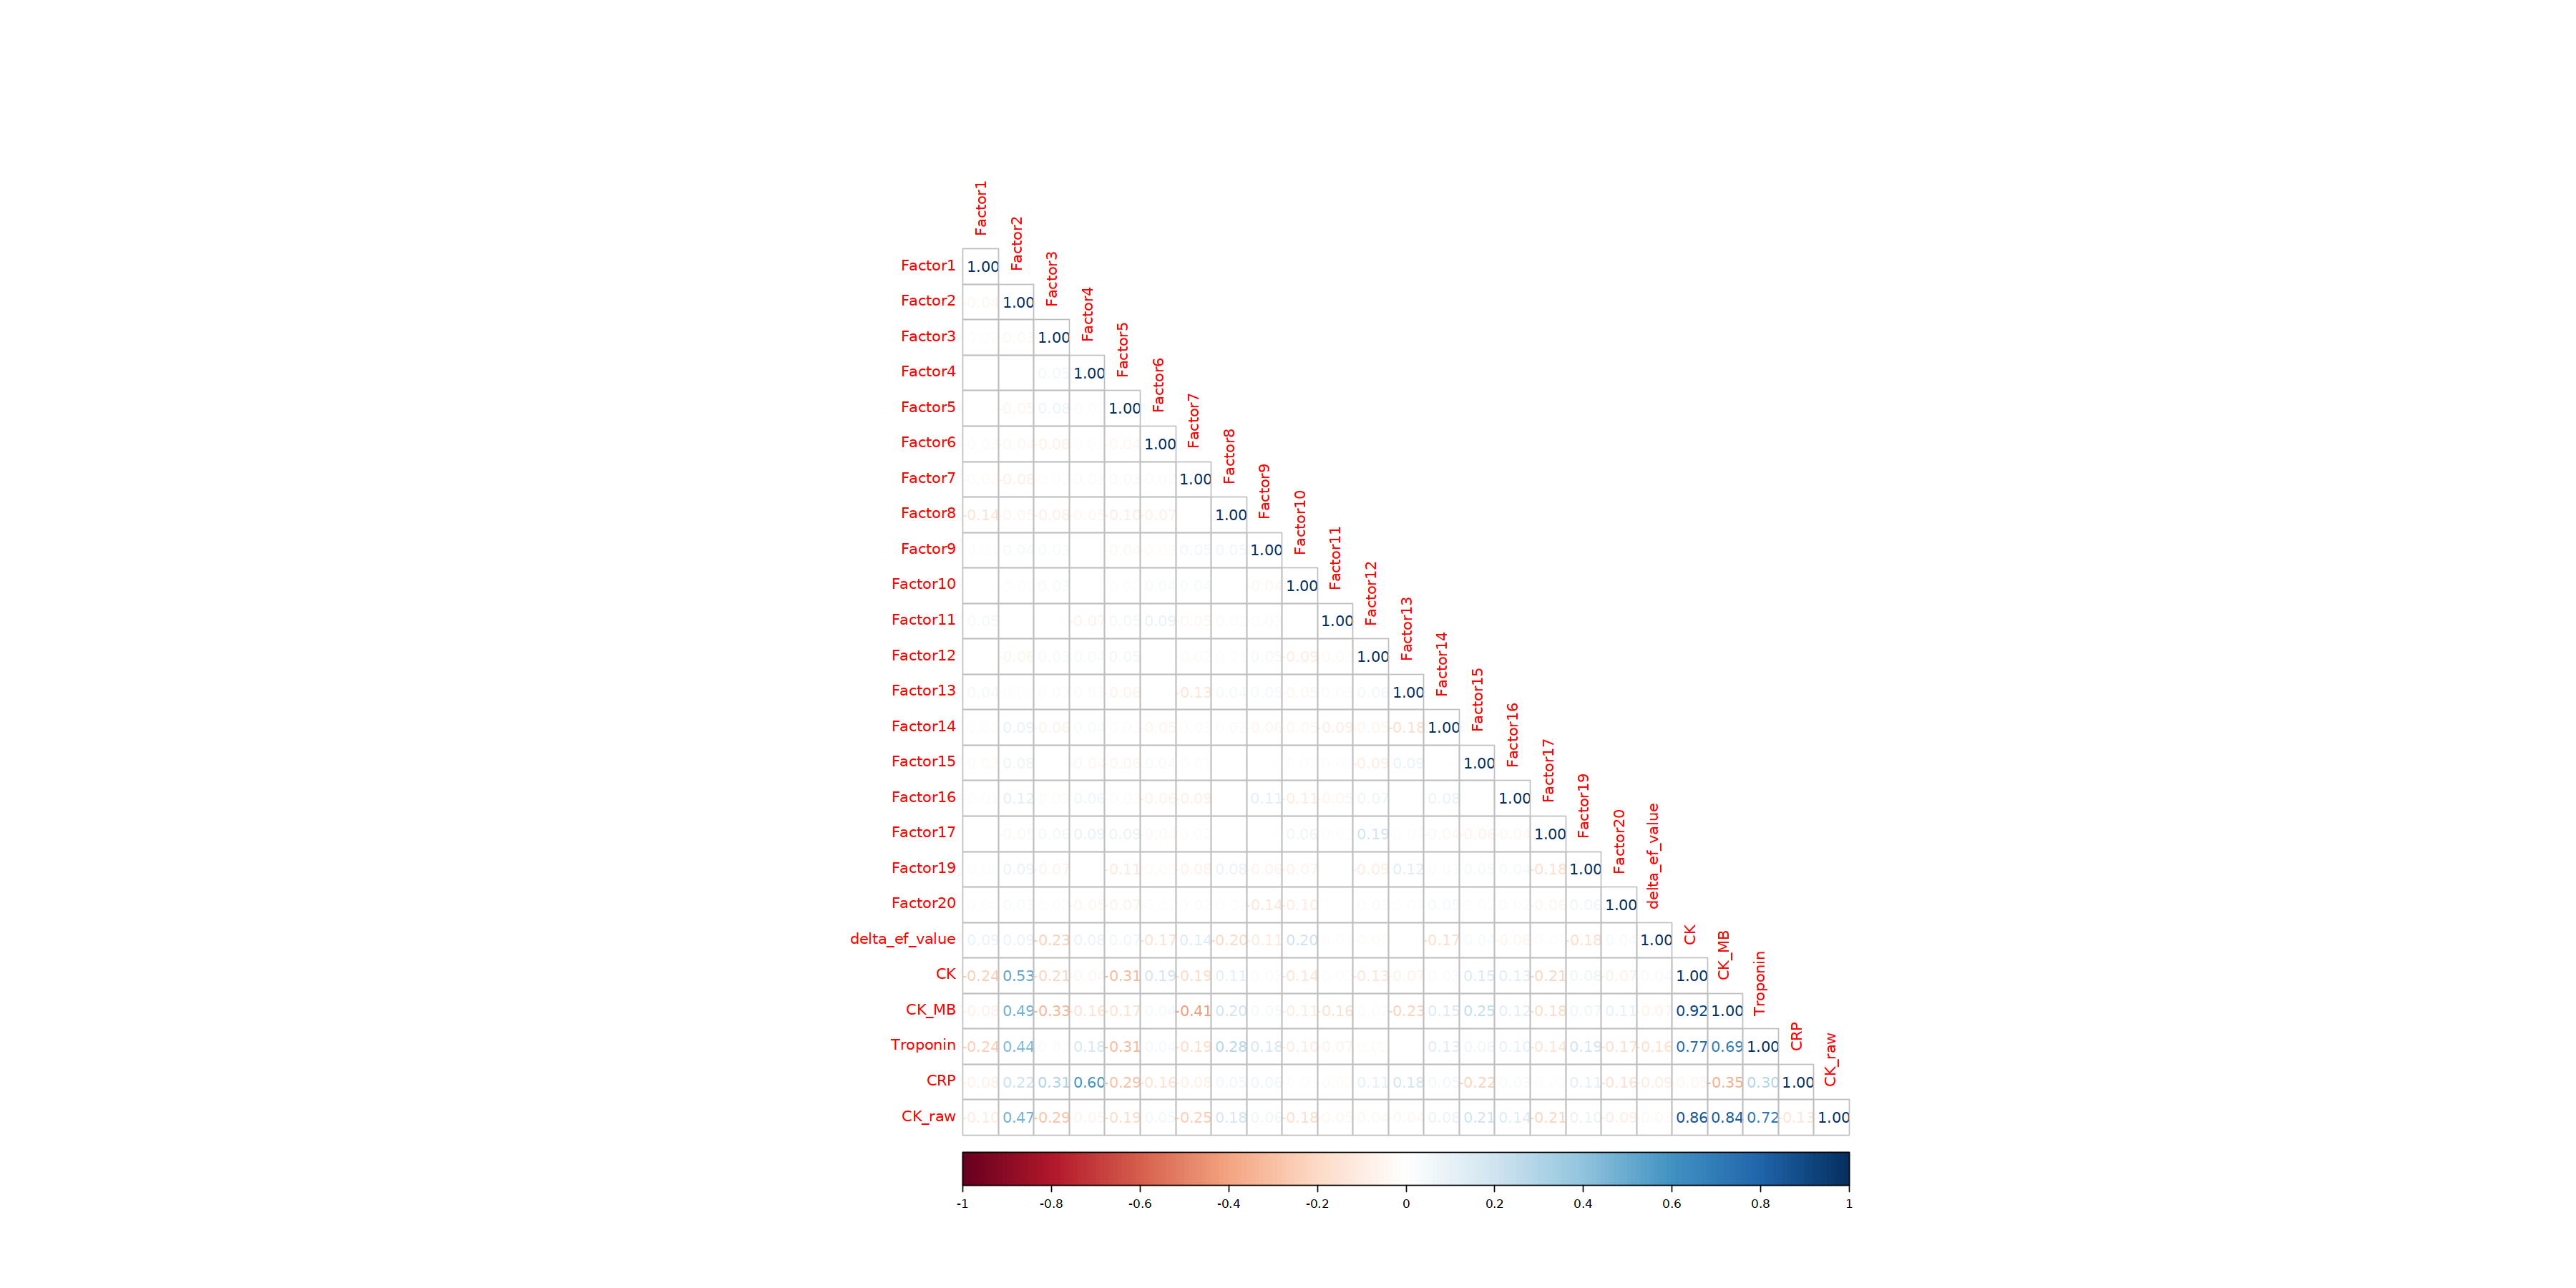

In [259]:
options(repr.plot.width=30, repr.plot.height=15)
corrplot(correlations, method = 'number',  type = 'lower')

In [260]:
### Correlation with delta-EF value (added in review proces)

In [261]:
merged_data_tp1 = merged_data[merged_data$measurement == 'TP1',]

In [262]:
nrow(merged_data_tp1)

[1] 26

In [263]:
figure_name = "FIG3_E3_EF_Factor4_Spearman_Correlation"

In [264]:
# Sizes of the plot
width_par = 2
height_par = 2

In [265]:
head(merged_data_tp1,2)

,sample_id,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
35,m1.1,0.4522834,1.590059,0.03268897,-0.1396731,0.5151998,-0.7895604,0.4313374,0.5203935,-0.1347053,⋯,4.321928,0.75446,3.1375035,1,176,acs,TP1,TP1_acs_subacute,NA,TP1_NA
36,m10.1,-0.3415061,2.374348,-0.93966867,-0.8162026,-0.7106899,-0.6172321,0.1132316,0.9506028,0.0816526,⋯,10.302639,4.69488,0.6780719,1,5116,acs,TP1,TP1_acs_w_infection,bad,TP1_bad


In [266]:
unique(merged_data_tp1$class)

[1] "acs"

In [267]:
merged_data_tp1[merged_data_tp1$measurement_class == 'TP1_acs_subacute',c('sample_id', 'delta_ef_value', 'measurement_class')]

,sample_id,delta_ef_value,measurement_class
,<chr>,<dbl>,<chr>
35,m1.1,NA,TP1_acs_subacute
59,m17.1,NA,TP1_acs_subacute
86,m24.1,NA,TP1_acs_subacute
122,m8.1,NA,TP1_acs_subacute


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 7 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 7 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


png 
  2

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 7 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 7 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


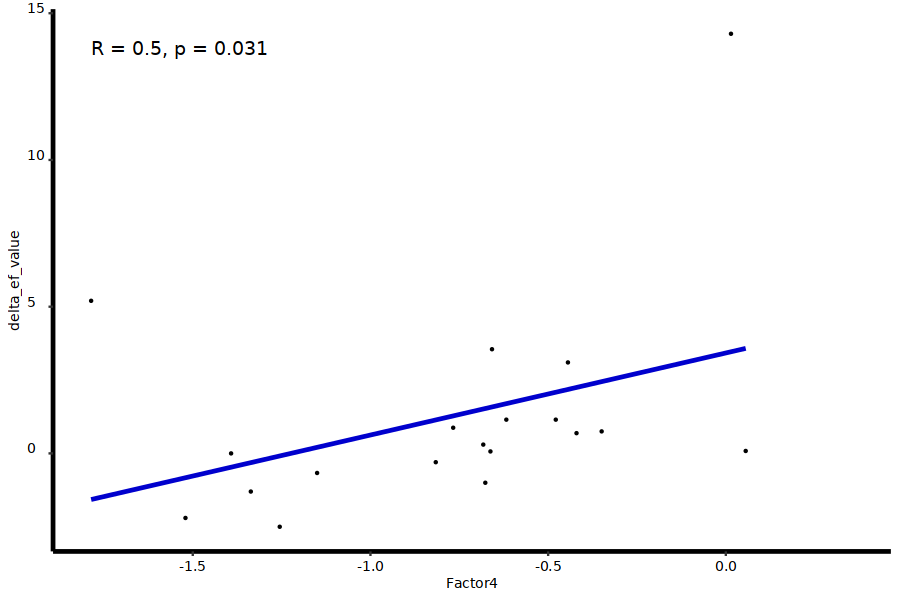

In [268]:
options(repr.plot.width=7.5, repr.plot.height=5)
pdf(paste0('figures/Supplementary_Figures/', figure_name,i,'_', name, train_opts$weight_views,'.pdf'), width =width_par, height = height_par)
p = ggplot(merged_data_tp1, aes(x = Factor4, y = delta_ef_value)) +
  geom_point(size = 0.2) + plot_config + geom_smooth(method='lm', col = 'blue3', se = FALSE) + stat_cor(method = 'spearman')
print(p)
dev.off()
p

# Plots

## Visualize Factor Patterns (Boxplot/ Lineplot)

### All factors pattern visualization

In [269]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [270]:
merged_data_long$measurement_concat = merged_data_long$measurement

merged_data_long$measurement_concat[merged_data_long$measurement == 'TP0'] = paste0(merged_data_long$measurement[merged_data_long$measurement == 'TP0'], '_',
            merged_data_long$class[merged_data_long$measurement == 'TP0'])

In [271]:
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_no_ccs', 'No CCS')
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_ccs', 'CCS')

In [272]:
merged_data_long$measurement_concat = factor(merged_data_long$measurement_concat, levels = c('No CCS','CCS','TP1','TP2','TP3','TP4'))

In [273]:
unique(merged_data_long$measurement_concat)

[1] No CCS CCS    TP1    TP2    TP3    TP4   
Levels: No CCS CCS TP1 TP2 TP3 TP4

In [274]:
# Specific Text Descriptions:
xlabel = xlab('') 
ylabel = ylab('Factor Value')

In [275]:
figure_name = "SUPP2_Factor_Pattern_Time"

In [276]:
# Sizes of the plot
width_par = 8.07
height_par = 3.5

In [277]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

vis_data = merged_data_long
g = ggplot(vis_data, aes(x=variable, y=value, fill = measurement_concat))  + 
    plot_config +
    xlabel + 
    ylabel +
    ccs_tp_fill +
    ggtitle('Pattern of factor values') + 
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 90))+
    geom_boxplot(outlier.size = 0.05, outlier.shape=NA) #+ geom_point(position=position_jitterdodge(jitter.width = 0.05), size = 0.005)
#print(g)

pdf(paste0('figures/Supplementary_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(g)
dev.off()


png 
  2

In [278]:
unique(vis_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

### Timeseries Visualization (good/ bad)

In [279]:
### Visualize with good/ poor outcome (poor = intermediate + bad)

In [280]:
# Specific Text Descriptions:
xlabel = xlab('Timepoint') 
ylabel = ylab('Median Value')

In [281]:
figure_name = "FIG3_E3_Factor_Patterns_Line_Plot_Classification"

In [282]:
# Sizes of the plot
width_par = 2
height_par = 2

In [283]:
for(i in c( 'Factor4')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    
    # Summarize data by relevant groups
    vis_data = vis_data %>% group_by(variable, measurement, delta_ef_value_class_summarized) %>% summarise(mean_value = mean(value) , median_value = median(value), sd_value = sd(value), quant_75 = quantile(value, probs = seq(0, 1, 0.25))['75%'], quant_25 = quantile(value, probs = seq(0, 1, 0.25))['25%'], n= n())
    
    # Remove ccs samples
    vis_data = vis_data[vis_data$measurement != 'TP0',]
    
    # Exclude NA
    vis_data = vis_data[!is.na(vis_data$delta_ef_value_class_summarized) ,]
    
    # Plot Median Plots
    

    pdf(paste0('figures/Final_Figures/', figure_name,i,'_', name, train_opts$weight_views,'.pdf'), width =width_par, height = height_par)
    g = ggplot(data=vis_data, aes(x=measurement, y=median_value, group=delta_ef_value_class_summarized, color = delta_ef_value_class_summarized)) +
      geom_line(aes(color = delta_ef_value_class_summarized) , size=line_size)+
      geom_point(aes(color=delta_ef_value_class_summarized), size=point_size) +ggtitle(paste0(i)) + xlabel + ylabel +plot_config + geom_errorbar(aes(ymin=quant_25, ymax=quant_75 ), width=.1) + 
    good_bad_color +
    theme(legend.position = 'none')
    print(g)
    dev.off()
    
   } 
    

`summarise()` has grouped output by 'variable', 'measurement'. You can override
using the `.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


### Timeseries Visualization (acs subtypes)

In [284]:
### Visualize with good/ poor outcome (poor = intermediate + bad)

In [285]:
# Specific Text Descriptions:
xlabel = xlab('Timepoint') 
ylabel = ylab('Median Value')

In [286]:
figure_name = "FIG3_E3_Factor_Patterns_Line_Plot_ACS_Subtypes"

In [287]:
# Sizes of the plot
width_par = 2
height_par = 2

In [288]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [289]:
for(i in c( 'Factor2')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    
    # Summarize data by relevant groups
    vis_data = vis_data %>% group_by(variable, measurement,classification) %>% summarise(mean_value = mean(value) , median_value = median(value), sd_value = sd(value), quant_75 = quantile(value, probs = seq(0, 1, 0.25))['75%'], quant_25 = quantile(value, probs = seq(0, 1, 0.25))['25%'])
    
    # Remove ccs samples
    vis_data = vis_data[vis_data$measurement != 'TP0',]
    
    # Exclude NA
    vis_data = vis_data[!is.na(vis_data$classification) ,]
    
    # Plot Median Plots
    

    pdf(paste0('figures/Final_Figures/', figure_name,i,'_', name, train_opts$weight_views,'.pdf'), width =width_par, height = height_par)
    g = ggplot(data=vis_data, aes(x=measurement, y=median_value, group=classification, color = classification)) +
      geom_line(aes(color = classification) , size=line_size)+
      geom_point(aes(color=classification), size=point_size) +ggtitle(paste0(i)) + xlabel + ylabel +plot_config + geom_errorbar(aes(ymin=quant_25, ymax=quant_75 ), width=.1) + 
    acs_subtypes_color +
    theme(legend.position = 'none')
    print(g)
    dev.off()
    
   } 
    

`summarise()` has grouped output by 'variable', 'measurement'. You can override
using the `.groups` argument.


### Healthy vs. ccs vs. acs

In [290]:
unique(merged_data_long$group)

[1] "no_ccs" "ccs"    "acs"

In [291]:
merged_data_long$group = str_replace(merged_data_long$group, 'ccs', 'CCS')
merged_data_long$group = str_replace(merged_data_long$group, 'no_CCS', 'No CCS')
merged_data_long$group = str_replace(merged_data_long$group, 'acs', 'ACS')

In [292]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [293]:
figure_name = "FIG3_E3_Factor_Patterns_Healthy_CCS_Boxplot_all_samples"

In [294]:
# Sizes of the plot
width_par = 2
height_par = 3

In [295]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

for(i in c('Factor1')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    g = ggplot(vis_data, aes(x=reorder(group, -as.numeric(as.factor(group))), y=value, fill=group))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_acs_color +
        ggtitle(i) + 
        geom_boxplot() +
        theme(legend.position = "none")
    #print(g)

    pdf(paste0('figures/Final_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(g)
    dev.off()
    }

In [296]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

### Time pattern (Factor2)

In [297]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [298]:
merged_data_long$measurement_plot = str_replace(merged_data_long$measurement, 'TP0', 'CCS')

In [299]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [300]:
figure_name = "FIG3_E3_Factor_Patterns_TP_all_samples"

In [301]:
# Sizes of the plot
width_par = 2
height_par = 2.8

In [302]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

for(i in c('Factor2')){  # attention filtered on w_o_infection + ccs class
    # Filter on factor
    vis_data = merged_data_long[(merged_data_long$variable == i) & (merged_data_long$classification %in% c('ccs', 'acs_w_o_infection')),]
    g = ggplot(vis_data, aes(x=measurement_plot, y=value, fill = measurement_plot))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_tp_fill +
        ggtitle(i) + 
        theme(legend.position = "none")+
        geom_boxplot() 
    #print(g)

    pdf(paste0('figures/Final_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(g)
    dev.off()
    }

### Time and ccs acs pattern to add to variance decomp

In [303]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

In [304]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [305]:
figure_name = "FIG1_E3_Factor_Patterns_TP_CCS"

In [306]:
# Sizes of the plot
width_par = 3
height_par = 3

In [307]:
ccs_tp_pattern = ggplot(merged_data_long, aes(x=variable, y=value, fill = class_measurement))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_tp_fill +
        ggtitle(i) + 
        theme(legend.position = "none")+
        geom_boxplot() 

## Plot explained variance overview

In [308]:
#### Plot complete explained variance

In [309]:
# Specific Text Descriptions:
xlabel = xlab('Factor') 
ylabel = ylab('View')

In [310]:
figure_name = "FIG1_E3_Variance Decomposition"

In [311]:
# Sizes of the plot
width_par = 8.07
height_par = 3.12

In [312]:
var_decomp = ggplot() + 
    scale_fill_gradient(low="white", high="black") + 
    xlabel + 
    ylabel +
    plot_config + theme(axis.text.x = element_text(angle = 90), legend.position = 'right')+ 
    geom_tile(data = data, mapping = aes(Var1,  Var2, fill= value))

var_decomp2 = ggplot() + 
    scale_fill_gradient(low="white", high="black") + 
    xlabel + 
    ylabel +
    plot_config + theme(axis.text.x = element_text(angle = 90))+ 
    geom_tile(data = data[data$Var1 %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),], mapping = aes(Var1,  Var2, fill= value))

In [313]:
pdf(paste0('figures/Final_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(var_decomp)
dev.off()

png 
  2

In [314]:
### Combine with total variance barplot per dimension

In [315]:
plot_complete = unique(data[,c('Var2', 'total_variance')])

In [316]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Clinical,Factor1,4.113069,58.68897
2,Clinical,Factor2,19.322238,58.68897


In [317]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Explained Variance')

In [318]:
comp_variance = ggplot(plot_complete, aes(x=Var2, y = total_variance, fill = Var2)) + 
                geom_bar(stat="identity") + coord_flip() + 
                xlabel + 
                ylabel +
                plot_config + cell_type_colors

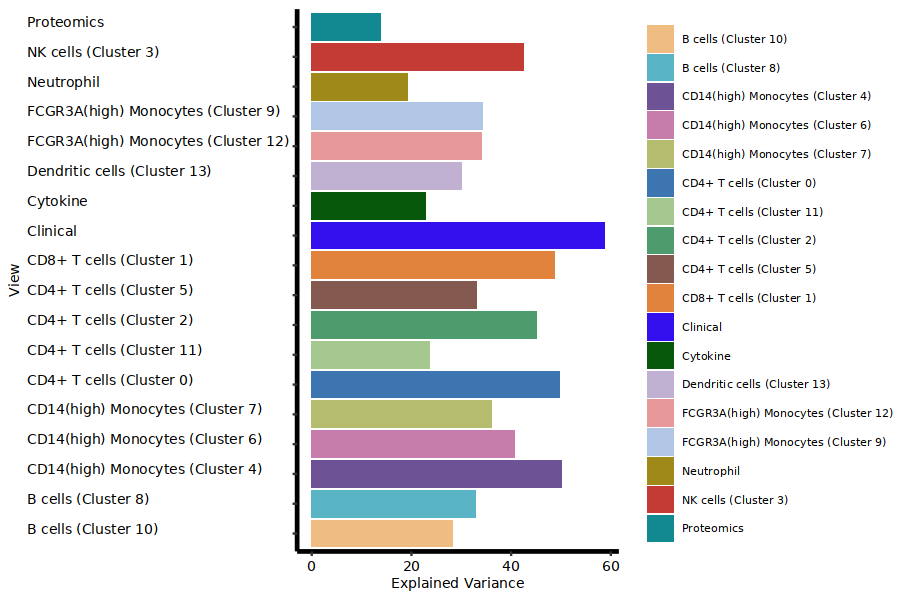

In [319]:
comp_variance

In [320]:
### Plot with variance per factor

In [321]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,5.574384
Factor2,Factor2,5.258483


In [322]:
# Specific Text Descriptions:
xlabel = xlab('Factor') 
ylabel = ylab('Explained Variance')

In [323]:
sort(unique(total_variance_factor$factor))

[1] "Factor1"  "Factor10" "Factor11" "Factor12" "Factor13" "Factor14"
 [7] "Factor15" "Factor16" "Factor17" "Factor18" "Factor19" "Factor2" 
[13] "Factor20" "Factor3"  "Factor4"  "Factor5"  "Factor6"  "Factor7" 
[19] "Factor8"  "Factor9"

In [324]:
### Combine both visualization

In [325]:
figure_name = "FIG1_E3_Variance Decomposition_Combined"

In [326]:
# Sizes of the plot
width_par = 8.07
height_par = 2.8

In [327]:
legend = get_legend(var_decomp)

In [328]:
combination1 = ggarrange(var_decomp + theme(legend.position = 'none'),
                     comp_variance + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), legend.position = 'none' ), 
                         align = 'h', nrow=1, widths = c(4,1))

In [329]:
combination1_ann = annotate_figure(
  combination1,
  right = legend
)

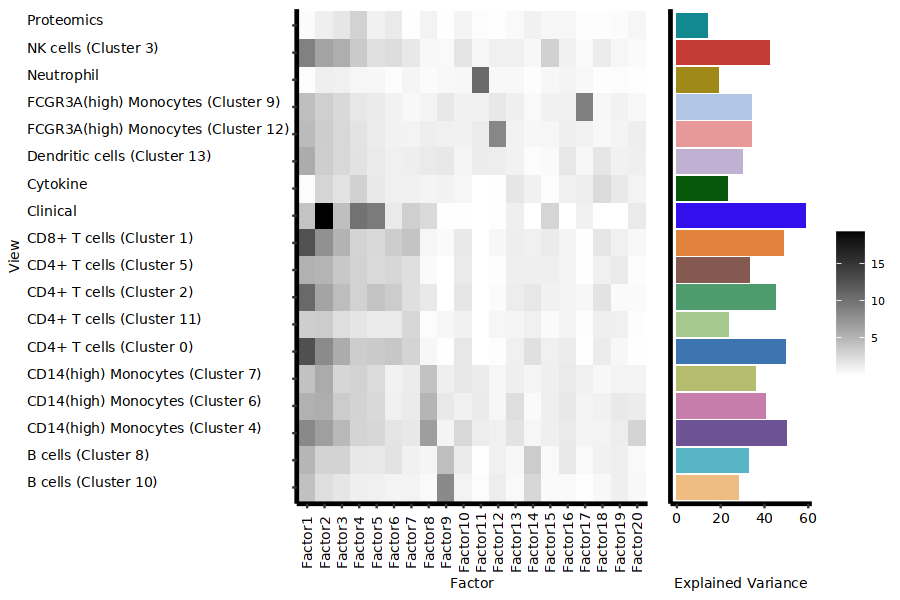

In [330]:
combination1_ann

In [331]:
pdf(paste0('figures/Final_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combination1_ann)
dev.off()

png 
  2

## Explained variance and percentage of features per factor

### Explained Variance

In [332]:
source('MS4_Plot_Config.r')

In [333]:
#### Plot explained variance

In [334]:
# choose factor
factor_var = c('Factor1', 'Factor2', 'Factor4')

In [335]:
# Specific Text Descriptions:
xlabel = xlab('Variance') 
ylabel = ylab('View')

In [336]:
figure_name = "FIG2_E3_Variance Decomposition_Factor"

In [337]:
# Sizes of the plot
width_par = 4
height_par = 3.12

In [338]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Clinical,Factor1,4.113069,58.68897
2,Clinical,Factor2,19.322238,58.68897


In [339]:
explained_variance_heatmap = list()

In [340]:
for(i in factor_var ){
    data_plot = data[data$Var1 == i,]
    data_plot$Var1 = 'Explained'
    
    explained_variance_heatmap[[i]] = ggplot() + scale_fill_gradient(low="white", high="black") + 
    ylabel + xlabel + 
    plot_config_heatmap  +
    geom_tile(data = data_plot, mapping = aes(Var1,  Var2, fill= value)
             )  +
    ggtitle(i)
    
    pdf(paste0('figures/Final_Figures/', figure_name, '_', i, '_', name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(explained_variance_heatmap[[i]])
    dev.off()
    }

### Feature Overview

In [341]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Percentage of total features')

In [342]:
figure_name = "FIG2_E3_Feature_Overview_Factor"

In [343]:
# Sizes of the plot
width_par = 4
height_par = 3.12

In [344]:
percentage_plot_1_perc = list()
percentage_plot_5_perc = list()

In [345]:
### Alternative 1 - percentage values
for(i in factor_var ){
    for(j in c('0.005')){
        
        percentage_plot_1_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = percentage*100, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip()  + cell_type_colors + theme(legend.position = 'none') +
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) +
        geom_hline(yintercept = 2*as.numeric(j)*100, 
                color = "black", size=1)
    }
    }

for(i in factor_var ){
    for(j in c('0.025')){
        
        percentage_plot_5_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = percentage*100, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip() +  cell_type_colors + theme(legend.position = 'none')+ 
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) +
        geom_hline(yintercept = 2*as.numeric(j)*100, 
                color = "black", size=1)
    }
    }

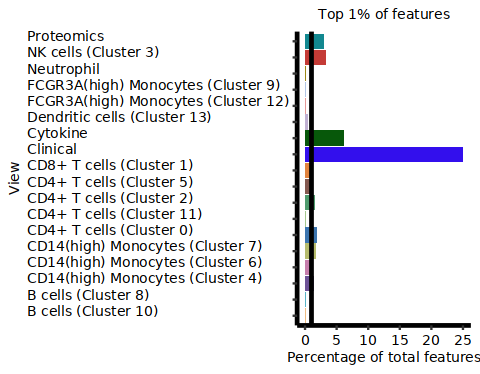

In [346]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
percentage_plot_1_perc[[i]]
#percentage_plot_5_perc[[i]]

In [347]:
### Absolute amount features Plot

In [348]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Amount features')

In [349]:
absolute_plot_1_perc = list()

In [350]:
# one selected threshold + absolute amount
for(i in factor_var ){
    for(j in c('0.005')){
        
        absolute_plot_1_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = n, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip()  +  cell_type_colors + theme(legend.position = 'none')+ 
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) 
    }
    }


In [351]:
i

[1] "Factor4"

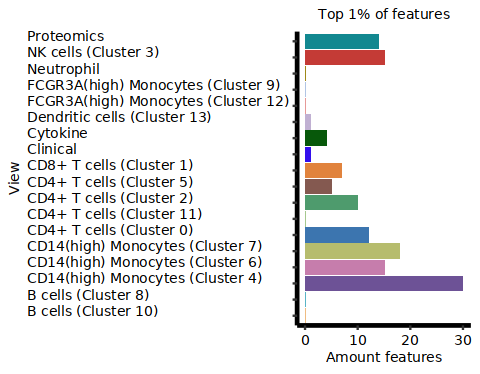

In [352]:
absolute_plot_1_perc[[i]]

### Combined Plots

In [353]:
### Variant 1 diff visualizations

In [354]:
source('MS4_Plot_Config.r')

In [355]:
figure_name = paste0("FIG2_E3_View_Overview_Plot")

In [356]:
# Sizes of the plot
width_par = 6.07
height_par =2.8

In [357]:
options(repr.plot.width=width_par, repr.plot.height=height_par)

for( i in factor_var){
    legend = get_legend(explained_variance_heatmap[[i]])
    
    combined1 = ggarrange(explained_variance_heatmap[[i]] + theme(legend.position = 'none'),
                         absolute_plot_1_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ), 
                         percentage_plot_1_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ),  
                          nrow=1, widths = c(2.2,1,1))
    combined1 = annotate_figure(combined1, right = legend)
    
    pdf(paste0('figures/Final_Figures/', figure_name, '_', i, '_', name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print( combined1)
    dev.off()
    }
    

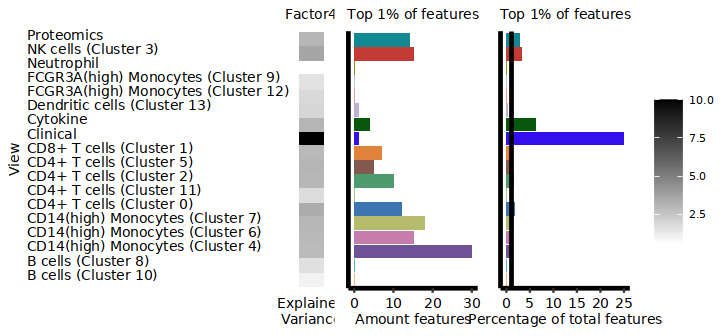

In [358]:
combined1

## Heatmap and Factor Plots

### All variables (without subsetting)

In [359]:
### Supplementary Heatmaps)
# Configs: 

# SUPPLEMENTARY for Factor 2

In [360]:
figure_name = "SUPP3_Heatmap_Pattern_sample_subset"

In [361]:
source('MS4_Plot_Config.r')

In [362]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"

In [363]:
heatmap_data$measurement2 = str_replace(heatmap_data$measurement2, 'TP0_ccs', 'CCS')
heatmap_data$measurement2 = str_replace(heatmap_data$measurement2, 'TP0_no_ccs', 'No CCS')

In [364]:
## specify faceting expression pattern heatmap
variable = 'measurement2'
heatmap_data$facet2 = heatmap_data[,variable]
heatmap_data$facet = paste0(heatmap_data$direction_sign, heatmap_data$view)

## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$view)
analysis_data_subset$facet2 = 'Absolute Factor Value'

In [365]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [366]:
top_frac = '0.005'

In [367]:
factor_var = 'Factor2'

In [368]:
# Specific Text Descriptions (heatmap):
xlabel_heatmap = xlab('Samples') 
ylabel_heatmap = ylab('View')

In [369]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Samples') 
ylabel_barplot = ylab('Absolute Factor Value')

In [370]:
### Plot parameters

In [371]:
# Sizes of the plot
width_par = 8.07
height_par = 11.4

In [372]:
# Plot Factor values as barplot

In [373]:
options(repr.plot.width=10, repr.plot.height=25)
factor_value_all_bar = ggplot(data = analysis_data_subset[(analysis_data_subset$fraction == top_frac) &
                                                          (analysis_data_subset$variable == factor_var),] , mapping = aes(x = gene,   y= abs(value)))+
                            plot_config_heatmap_supp  + 
                            geom_bar(stat="identity", width = 0.1) + 
                            coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme( axis.text.y = element_text( hjust = 1, vjust =1))+
                            facet_grid(facet  ~ facet2, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
                            ggtitle('')


In [374]:
#options(repr.plot.width=width_par, repr.plot.height=height_par)
#factor_value_all_bar

In [375]:
### Expression level heatmap

In [376]:
unique(heatmap_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [377]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
all_heatmap = ggplot(data = heatmap_data[(heatmap_data$variable == factor_var) & 
                                         (heatmap_data$fraction == top_frac) &
                                         (heatmap_data$classification %in% c('ccs', 'acs_w_o_infection')),], # TBD whether to filter on sample subset
                     mapping = aes(sample_id, gene,  fill= expression_value)) +
    scale_fill_gradient2(low="navy", high="red", midpoint = 0) + 
    geom_tile() + 
    xlabel_heatmap +
    ylabel_heatmap +
    plot_config_heatmap_supp  + theme(axis.text.x = element_blank()) + 
    facet_grid(facet  ~facet2, scales = 'free', space = 'free',  switch = "y") + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.4, "cm"), strip.text.y.left = element_text(angle=0))+
    theme( axis.text.y = element_text( hjust = 1, vjust =1)) + 
    ggtitle(paste0('Normalized Expression Values of top ',as.numeric(top_frac) *100 *2, '% features'))

    

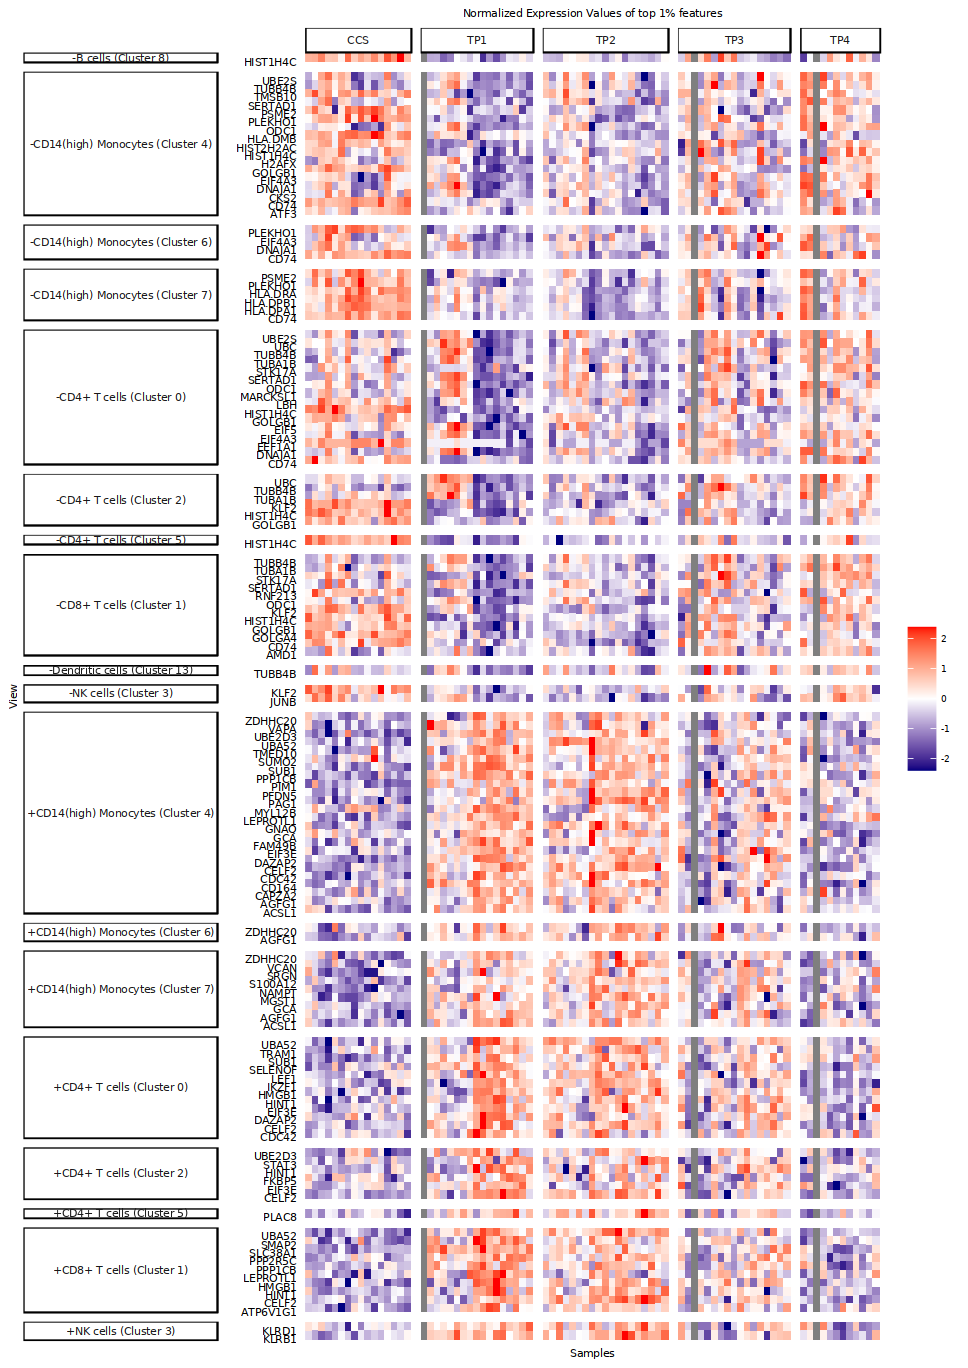

In [378]:
all_heatmap

In [379]:
### Combined factor plot and heatmap

In [380]:
legend =  get_legend(all_heatmap)

In [381]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
combined = ggarrange(all_heatmap + theme(legend.position = 'none'),
         factor_value_all_bar + 
          theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), strip.background.y = element_blank() , strip.text.y = element_blank()),  
         nrow=1, widths = c(4,1), align = 'h')
combined = annotate_figure(combined, right = legend)

In [382]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,factor_var, '_',  top_frac,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combined)
dev.off()

png 
  2

In [383]:
### Supplementary Heatmaps)  - other with complete samples
# Configs: 

# SUPPLEMENTARY for Factor 1: variable = 'measurement2'
# SUPPLEMENTARY for Factor 4: variable = 'tp_outcome'

In [384]:
figure_name = "SUPP3_Heatmap_Pattern_"

In [385]:
source('MS4_Plot_Config.r')

In [386]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"                 
[25] "facet2"

In [387]:
unique(heatmap_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP1_bad"  "TP2_bad"  "TP3_bad"  "TP2_NA"  
 [7] "TP3_NA"   "TP4_NA"   "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

In [388]:
heatmap_data$tp_outcome_new = heatmap_data$tp_outcome

In [389]:
heatmap_data$tp_outcome_new = str_replace(heatmap_data$tp_outcome_new , 'bad' , 'poor')
heatmap_data$tp_outcome_new = str_replace(heatmap_data$tp_outcome_new , '_' , ' (')
heatmap_data$tp_outcome_new = paste0(heatmap_data$tp_outcome_new, ')')

In [390]:
heatmap_data$tp_outcome_new[heatmap_data$tp_outcome_new == 'TP0(NA)'] = heatmap_data$class[heatmap_data$tp_outcome_new == 'TP0(NA)']
heatmap_data$tp_outcome_new = str_replace(heatmap_data$tp_outcome_new , 'ccs' , 'CCS')
heatmap_data$tp_outcome_new = str_replace(heatmap_data$tp_outcome_new , 'no_CCS' , 'No CCS')

In [391]:
## specify faceting expression pattern heatmap
variable = 'measurement2'
heatmap_data$facet2 = heatmap_data[,variable]
heatmap_data$facet = paste0(heatmap_data$direction_sign, heatmap_data$view)

## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$view)
analysis_data_subset$facet2 = 'Absolute Factor Value'

In [392]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [393]:
top_frac = '0.005'

In [394]:
factor_var = 'Factor1'

In [395]:
### Plot parameters

In [396]:
# Sizes of the plot
width_par = 8.07
height_par = 11.4

In [397]:
# Plot Factor values as barplot

In [398]:
options(repr.plot.width=10, repr.plot.height=25)
factor_value_all_bar = ggplot(data = analysis_data_subset[(analysis_data_subset$fraction == top_frac) &
                                                          (analysis_data_subset$variable == factor_var),] , mapping = aes(x = gene,   y= abs(value)))+
                            plot_config_heatmap_supp  + 
                            geom_bar(stat="identity", width = 0.1) + 
                            coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme( axis.text.y = element_text( hjust = 1, vjust =1))+
                            facet_grid(facet  ~ facet2, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
                            ggtitle('')


In [399]:
### Expression level heatmap

In [400]:
unique(heatmap_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [401]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
all_heatmap = ggplot(data = heatmap_data[(heatmap_data$variable == factor_var) & 
                                         (heatmap_data$fraction == top_frac),],
                     mapping = aes(sample_id, gene,  fill= expression_value)) +
    scale_fill_gradient2(low="navy", high="red", midpoint = 0) + 
    geom_tile() + 
    xlabel_heatmap +
    ylabel_heatmap +
    plot_config_heatmap_supp  + theme(axis.text.x = element_blank()) + 
    facet_grid(facet  ~facet2, scales = 'free', space = 'free',  switch = "y") + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.01, "cm"), strip.text.y.left = element_text(angle=0), strip.text.x.top = element_text(angle=90), panel.spacing = unit(0.1, "cm"))+
    theme( axis.text.y = element_text( hjust = 1, vjust =1)) + 
    ggtitle(paste0('Normalized Expression Values of top ',as.numeric(top_frac) *100 *2, '% features'))

    

In [402]:
### Combined factor plot and heatmap

In [403]:
legend =  get_legend(all_heatmap)

In [404]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
combined = ggarrange(all_heatmap + theme(legend.position = 'none'),
         factor_value_all_bar + 
          theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), strip.background.y = element_blank() , strip.text.y = element_blank()),  
         nrow=1, widths = c(5,1), align = 'h')
combined = annotate_figure(combined, right = legend)

In [405]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,factor_var, '_',  top_frac,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combined)
dev.off()

png 
  2

### Only one cell-type/ view

In [406]:
### Supplementary Heatmaps)  - other with complete samples
# Configs: 

# Figure for Factor 2:  factor_var = 'Factor2', 
#                       top_frac = '0.0025', 
#                       filtered_samples = TRUE,
#                       variable = 'measurement' 
#                       cluster = c('Cluster 0')

In [407]:
figure_name = "FIG4_E3_Heatmap_Cluster"

In [408]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [409]:
top_frac = '0.0025'

In [410]:
factor_var = 'Factor2'

In [411]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"                 
[25] "facet2"                          "tp_outcome_new"

In [412]:
#analysis_data_subset[(analysis_data_subset$variable == 'Factor2') & (analysis_data_subset$cluster == 'Clinical'),]

In [413]:
filtered_samples = TRUE

## specify on whether to subset on a specific set of samples
if(filtered_samples == FALSE){
    samples_filter = unique(heatmap_data$sample_id)
    }

if(filtered_samples == TRUE){
    samples_filter = unique(heatmap_data$sample_id[
        heatmap_data$classification %in% c('ccs', 'acs_w_o_infection')])
        }


In [414]:
length(samples_filter)

[1] 81

In [415]:
## specify faceting
variable = 'measurement'
heatmap_data$facet2 = heatmap_data[,variable]
heatmap_data$facet = paste0(heatmap_data$direction_sign, heatmap_data$cluster)

## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$cluster)
analysis_data_subset$facet2 = 'Factor Weight'

In [416]:
## specify data subset based on facet
#facet_subset = c('TP0_ccs', 'TP1_acs_w_o_infection', 'TP2_acs_w_o_infection','TP3_acs_w_o_infection','TP4_acs_w_o_infection')
facet_subset = unique(heatmap_data$facet2)
heatmap_data_plot = heatmap_data[heatmap_data$facet2 %in% facet_subset,]

In [417]:
## subset on samples
heatmap_data_plot = heatmap_data_plot[heatmap_data_plot$sample_id %in% samples_filter,]

In [418]:
unique(heatmap_data_plot$cluster)

[1] "Neutrophil" "Cluster 9"  "Cluster 5"  "Cluster 7"  "Cytokine"  
 [6] "Cluster 4"  "Cluster 12" "Cluster 2"  "Cluster 0"  "Cluster 6" 
[11] "Cluster 13" "Cluster 11" "Cluster 1"  "Cluster 10" "Proteomics"
[16] "Cluster 3"  "Cluster 8"  "Clinical"

In [419]:
unique(heatmap_data_plot$cell_type)

[1] "Neutrophil"              "FCGR3A(high) Monocytes "
 [3] "CD4+ T cells "           "CD14(high) Monocytes "  
 [5] "Cytokine"                "Dendritic cells "       
 [7] "CD8+ T cells "           "B cells "               
 [9] "Proteomics"              "NK cells "              
[11] "Clinical"

In [420]:
## subset based on view or clusters
view = unique(heatmap_data_plot$cell_type)
cluster = c('Cluster 0')
heatmap_data_plot = heatmap_data_plot[(heatmap_data_plot$cell_type %in% view) & (heatmap_data_plot$cluster %in% cluster),]
analysis_data_subset_plot = analysis_data_subset[(analysis_data_subset$cell_type %in% view) & (analysis_data_subset$cluster %in% cluster),]

In [421]:
unique(analysis_data_subset_plot$facet)

[1] "+Cluster 0" "-Cluster 0"

In [422]:
#head(analysis_data_subset_plot[analysis_data_subset_plot$fraction == '0.025',],10)

In [423]:
# Specific Text Descriptions:
xlabel_heatmap = xlab('Samples') 
ylabel_heatmap = ylab('Feature')

In [424]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Feature') 
ylabel_barplot = ylab('Factor Weight')

In [425]:
# Sizes of the plot
width_par = 8.07
width_par_bar = 8
height_par =3.5

In [426]:
# Plot Factor values as barplot

In [427]:
options(repr.plot.width=width_par_bar, repr.plot.height=height_par)
factor_value_all_bar = ggplot(data = analysis_data_subset_plot[(analysis_data_subset_plot$fraction == top_frac) &(analysis_data_subset_plot$variable == factor_var),] , mapping = aes(x = gene,   y= value))+
                            plot_config + 
                            geom_bar(stat="identity", width = 0.3) + 
                            coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme( axis.text.y = element_text( hjust = 1, vjust =1))+
                            facet_grid(facet  ~ facet2, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
                            ggtitle('')


In [428]:
#analysis_data_subset[(analysis_data_subset$variable == 'Factor2') & (analysis_data_subset$gene == 'CSF3R'),]

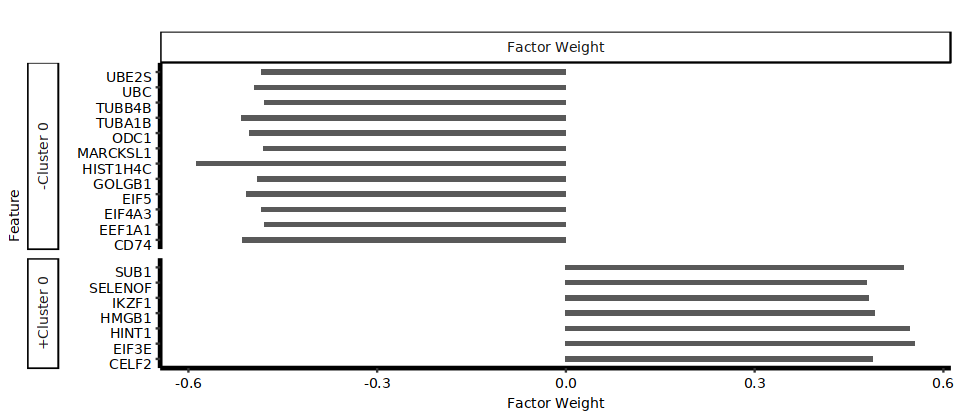

In [429]:
factor_value_all_bar

In [430]:
# Expression Heatmap Plot

In [431]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
cell_type_heatmap = ggplot(data = heatmap_data_plot[(heatmap_data_plot$variable == factor_var) &   (heatmap_data_plot$fraction == top_frac),], mapping = aes(sample_id, gene,  fill= expression_value)) +
    scale_fill_gradient2(low="navy", high="red", midpoint = 0) + 
    geom_tile() +
    xlabel_heatmap +
    ylabel_heatmap +
    plot_config_heatmap + theme(axis.text.x = element_blank(), axis.title.y = element_blank()) + 
    theme( axis.text.y = element_text( hjust = 1, vjust =1))+
    facet_grid(facet  ~facet2, scales = 'free', space = 'free',  switch = "y") + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
    ggtitle(paste0( ' Normalized Expression Values of top ', as.numeric(top_frac) *100*2 ,'% features'))


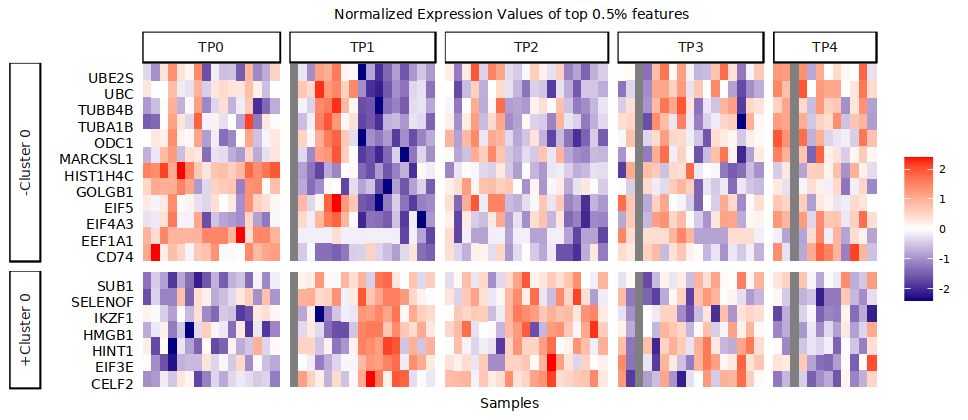

In [432]:
cell_type_heatmap

In [433]:
### Combined factor plot and heatmap

In [434]:
legend =  get_legend(cell_type_heatmap)

In [435]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
combined_heatmap = ggarrange(cell_type_heatmap + theme(legend.position = 'none'),
         factor_value_all_bar + 
         theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), strip.background.y = element_blank() , strip.text.y = element_blank()),  
         nrow=1, widths = c(3.5,1), align = 'h')
combined_heatmap = annotate_figure(combined_heatmap, right = legend)

In [436]:
pdf(paste0('figures/Final_Figures/', figure_name,factor_var, '_',filtered_samples, '_',  top_frac,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combined_heatmap)
dev.off()

png 
  2

In [437]:
unique(heatmap_data_plot$classification[(heatmap_data_plot$variable == factor_var) &   (heatmap_data_plot$fraction == top_frac)])

[1] "ccs"               "acs_w_o_infection"

### Only one cell-type/ view + specific set of genes

In [438]:
figure_name = "FIG2_E3_View_Overview_PlotV2"

In [439]:
factor_var = 'Factor1'

In [440]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [441]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Samples') 
ylabel_barplot = ylab('View')

In [442]:
# Sizes of the plot
width_par = 12
height_par = 5

In [443]:
unique(heatmap_data$cell_type)

[1] "Proteomics"              "CD14(high) Monocytes "  
 [3] "CD4+ T cells "           "Neutrophil"             
 [5] "CD8+ T cells "           "B cells "               
 [7] "NK cells "               "FCGR3A(high) Monocytes "
 [9] "Dendritic cells "        "Cytokine"               
[11] "Clinical"

In [444]:
unique(heatmap_data$cluster)

[1] "Proteomics" "Cluster 4"  "Cluster 5"  "Cluster 6"  "Cluster 0" 
 [6] "Neutrophil" "Cluster 7"  "Cluster 1"  "Cluster 10" "Cluster 3" 
[11] "Cluster 11" "Cluster 9"  "Cluster 12" "Cluster 2"  "Cluster 8" 
[16] "Cluster 13" "Cytokine"   "Clinical"

In [445]:
view = c('CD4+ T cells ', 'CD8+ T cells ', 'NK cells ')

In [446]:
cluster = c('Cluster 0', 'Cluster 1', 'Cluster 3')

In [447]:
genes = c('CD3E', 'ICAM3', 'TRAC', 'PRDX2', 'CORO1A', 'JUNB', 'CD37', 'FOSB')

In [448]:
unique(heatmap_data$class)

[1] "no_ccs" "ccs"    "acs"

In [449]:
## specify faceting
variable = 'class'
heatmap_data$facet2 = heatmap_data[,variable]
heatmap_data_plot$facet = paste0(heatmap_data_plot$direction_sign, heatmap_data_plot$cluster)

## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$cluster)
analysis_data_subset$facet2 = 'Factor Value'

In [450]:
### subset samples based on faceting
facet_subset = c('ccs', 'no_ccs')
heatmap_data_plot = heatmap_data_plot[heatmap_data_plot$facet2 %in% facet_subset,]

In [451]:
unique(heatmap_data_plot$facet)

character(0)

In [452]:
## subset based on selected genes and cell-types
heatmap_data_plot = heatmap_data_plot[heatmap_data_plot$fraction == max(heatmap_data$fraction),]
heatmap_data_plot = heatmap_data_plot[(heatmap_data_plot$cell_type %in% view) & (heatmap_data_plot$gene %in% genes)  & (heatmap_data_plot$cluster %in% cluster),]

analysis_data_subset_plot = analysis_data_subset[analysis_data_subset$fraction == max(analysis_data_subset$fraction),]
analysis_data_subset_plot = analysis_data_subset_plot[(analysis_data_subset_plot$cell_type %in% view) & (analysis_data_subset_plot$gene %in% genes)  & (analysis_data_subset_plot$cluster %in% cluster),]

In [453]:
# Plot Factor values as barplot

In [454]:
levels(factor(analysis_data_subset_plot$facet, levels=sort(unique(analysis_data_subset_plot$facet))))

[1] "-Cluster 0" "-Cluster 1" "-Cluster 3" "+Cluster 0" "+Cluster 1"
[6] "+Cluster 3"

In [455]:
levels(factor(heatmap_data_plot$facet, levels=sort(unique(heatmap_data_plot$facet))))

character(0)

In [456]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
factor_value_all_bar = ggplot(data = analysis_data_subset_plot[ (analysis_data_subset_plot$variable == factor_var),] , mapping = aes(x = gene,   y= value))+
                            plot_config + 
                            geom_bar(stat="identity") + 
                            coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme( axis.text.y = element_text( hjust = 1, vjust =1))+
                            facet_grid(facet  ~ facet2, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
                            ggtitle('')


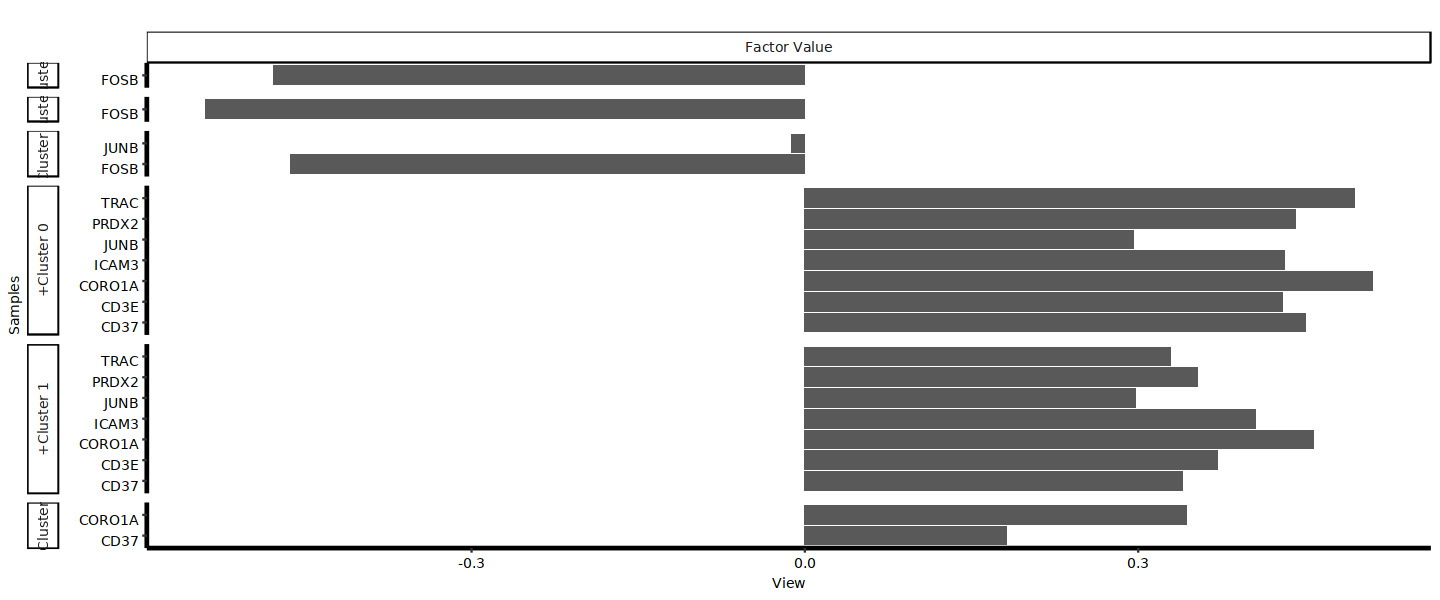

In [457]:
factor_value_all_bar

In [458]:
### Plot heatmap for selected clusters and cell-types

In [459]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
gene_subset_heatmap = ggplot(data = heatmap_data_plot[heatmap_data_plot$variable == factor_var,], mapping = aes(sample_id, gene,  fill= expression_value)) +
    scale_fill_gradient2(low="navy", high="red", midpoint = 0) + 
    geom_tile() +
    xlabel + 
    ylabel +
    plot_config_heatmap + 
    theme(axis.text.x = element_blank(), axis.title.y = element_blank()) + 
    theme( axis.text.y = element_text( hjust = 1, vjust =1))+
    facet_grid(facet ~facet2, scales = 'free', space = 'free',  switch = "y") + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
    ggtitle(paste0('Normalized Expression Values ' ))


In [460]:
### Combined factor plot and heatmap

In [461]:
#options(repr.plot.width=width_par, repr.plot.height=height_par)
#ggarrange(gene_subset_heatmap,
#         factor_value_all_bar + 
#          theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), strip.background.y = element_blank() , strip.text.y = element_blank()),  
#         nrow=1, widths = c(3,1), align = 'h')

### Only top ligands

In [462]:
### For main figures
# Factor 2: 
## factor_var = 'Factor2'
## top_amount = 15

# Factor 1:
## factor_var = 'Factor1'
## top_amount = 10


In [463]:
figure_name = "FIG8_E3_Barplot_Features"

In [464]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [465]:
top_frac = '0.5'

In [466]:
factor_var = 'Factor1'

In [467]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"                 
[25] "facet2"                          "tp_outcome_new"

In [468]:
## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$cluster)
analysis_data_subset$facet2 = 'Factor Weight'

In [469]:
## subset based on view or clusters
view = unique(analysis_data_subset$cell_type)
cluster = unique(analysis_data_subset$cluster)
analysis_data_subset_plot = analysis_data_subset[(analysis_data_subset$cell_type %in% view) & (analysis_data_subset$cluster %in% cluster),]

In [470]:
## Subset based on selected factor value and top frac

In [471]:
analysis_data_subset_plot = analysis_data_subset_plot[analysis_data_subset_plot$variable == factor_var,]
analysis_data_subset_plot = analysis_data_subset_plot[analysis_data_subset_plot$fraction== top_frac,]

In [472]:
#ligands

In [473]:
## Subset to visualize only ligands
analysis_data_subset_plot = analysis_data_subset_plot[analysis_data_subset_plot$gene %in% ligands,]

In [474]:
#sort(ligands)

In [475]:
## amount of top ligands to show
top_amount = 10

In [476]:
#head(analysis_data_subset_plot[(analysis_data_subset_plot$gene %in%  c('HMGB1', 'CMTM6', 'NAMPT', 'PTPRC')) & (analysis_data_subset_plot$view == 'CD14(high) Monocytes (Cluster 4)'),],4)

In [477]:
analysis_data_subset_plot = head(analysis_data_subset_plot[order(abs(analysis_data_subset_plot$value), decreasing = TRUE),], top_amount)

In [478]:
#head(analysis_data_subset_plot)

In [479]:
#### VERSION 1: HORIZONTAL

In [480]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Ligand') 
ylabel_barplot = ylab('Factor Weight')

In [481]:
# Sizes of the plot
width_par = 2.8
height_par =2.2

In [482]:
# Plot Factor values as barplot

In [483]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
factor_value_all_bar = ggplot(data = analysis_data_subset_plot[(analysis_data_subset_plot$fraction == top_frac) &(analysis_data_subset_plot$variable == factor_var),] , mapping = aes(x = gene,   y= value))+
                            plot_config + 
                            geom_bar(stat="identity", width = 0.3) + 
                            coord_flip()+
                            xlabel_barplot + ylim(c(-max(abs(analysis_data_subset_plot$value)), max(abs(analysis_data_subset_plot$value)))) +
                            ylabel_barplot  +
                            facet_grid(facet  ~., scales = 'free', space = 'free', switch = 'y') + 
                            theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.2, "cm"), axis.text.y = element_text( hjust = 1, vjust =1), strip.text.y.left = element_text(angle = 0),  plot.title = element_text(hjust = 2))+
                            ggtitle(paste0('Top ',top_amount , ' ligands factor weight' ))


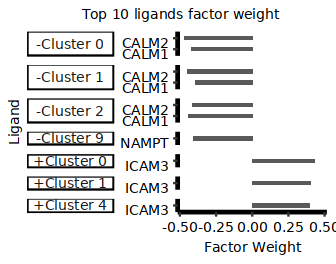

In [484]:
factor_value_all_bar 

In [485]:
pdf(paste0('figures/Final_Figures/', figure_name,factor_var, '_',  top_amount ,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(factor_value_all_bar )
dev.off()

png 
  2

In [486]:
#### VERSION 2: VERTICAL

In [487]:
figure_name = "FIG8_E3_Barplot_Horizontal_Features"

In [488]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Ligand') 
ylabel_barplot = ylab('Factor Weight')

In [489]:
# Sizes of the plot
width_par = 8.07
height_par =2.5

In [490]:
# Plot Factor values as barplot

In [491]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
factor_value_all_bar = ggplot(data = analysis_data_subset_plot[(analysis_data_subset_plot$fraction == top_frac) &(analysis_data_subset_plot$variable == factor_var),] , mapping = aes(x = gene,   y= value))+
                            plot_config + 
                            geom_bar(stat="identity", width = 0.3) + 
                            xlabel_barplot + ylim(c(-max(abs(analysis_data_subset_plot$value)), max(abs(analysis_data_subset_plot$value)))) +
                            ylabel_barplot  +
                            facet_grid(. ~ cluster, scales = 'free', space = 'free', switch = 'y') + 
                            theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"), axis.text.y = element_text( hjust = 1, vjust =1), strip.text.y.left = element_text(angle = 0), axis.text.x = element_text(angle = 90))+
                            ggtitle(paste0('Top ',top_amount , ' ligands factor weight' ))


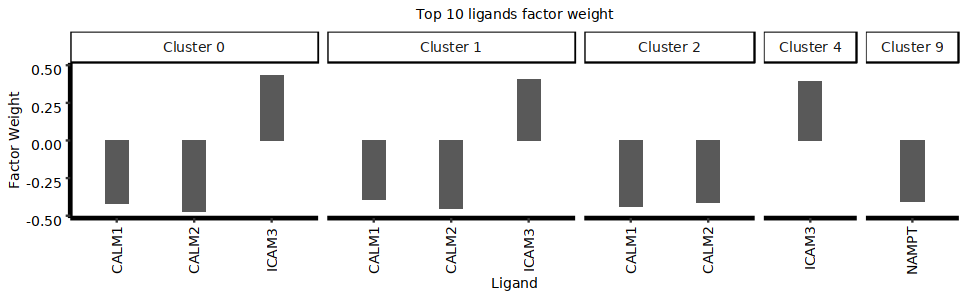

In [492]:
factor_value_all_bar 

In [493]:
pdf(paste0('figures/Final_Figures/', figure_name,factor_var, '_',  top_amount ,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(factor_value_all_bar )
dev.off()

png 
  2

### Factor value barplot for selected cell-types

In [494]:
### Supplementary Heatmaps)  - other with complete samples
# Configs: 

# Figure for Factor 4:  factor_var = 'Factor4', 
#                       top_frac = '0.005', 
#                       cluster = c('Cluster 3','Cytokine','Clinical','Proteomics'   )
#width_par_bar =6
#height_par = 2.8


# Figure for Factor 1: top_frac = '0.005', 
#                      factor_var = 'Factor1', 
#                      cluster = c('Cluster 0','Cluster 2' , 'Cluster 1'  )

In [495]:
figure_name = "FIG4_E3_Barplot_Cluster"

In [496]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [497]:
top_frac = '0.005'

In [498]:
factor_var = 'Factor1'

In [499]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"                 
[25] "facet2"                          "tp_outcome_new"

In [500]:
## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$cluster)
analysis_data_subset$facet2 = 'Factor Weight'

In [501]:
unique(analysis_data_subset$cell_type)

[1] "CD4+ T cells "           "CD8+ T cells "          
 [3] "CD14(high) Monocytes "   "Proteomics"             
 [5] "Clinical"                "NK cells "              
 [7] "Cytokine"                "B cells "               
 [9] "Dendritic cells "        "FCGR3A(high) Monocytes "
[11] "Neutrophil"

In [502]:
## subset based on view or clusters
view = unique(analysis_data_subset$cell_type)
cluster = c('Cluster 0' ,  'Cluster 2' )
analysis_data_subset_plot = analysis_data_subset[(analysis_data_subset$cell_type %in% view) & (analysis_data_subset$cluster %in% cluster),]

In [503]:
unique(analysis_data_subset_plot$facet)

[1] "+Cluster 0" "+Cluster 2" "-Cluster 2" "-Cluster 0"

In [504]:
#head(analysis_data_subset_plot[analysis_data_subset_plot$fraction == '0.025',],10)

In [505]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Feature') 
ylabel_barplot = ylab('Factor Weight')

In [506]:
# Sizes of the plot
width_par_bar =8
height_par = 2

In [507]:
# Plot Factor values as barplot

In [508]:
options(repr.plot.width=width_par_bar, repr.plot.height=height_par)
factor_value_all_bar = ggplot(data = analysis_data_subset_plot[(analysis_data_subset_plot$fraction == top_frac) &(analysis_data_subset_plot$variable == factor_var),] , mapping = aes(x = gene,   y= value))+
                            plot_config + 
                            geom_bar(stat="identity", width = 0.3) + 
                            #coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme(axis.title.x = element_blank(), axis.text.x = element_text( hjust = 1, vjust =1, angle = 90))+
                            facet_grid(.  ~ cluster, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.1, "cm"))+
                            ggtitle(paste0( 'Factor Values of top ', as.numeric(top_frac) *100*2 ,'% features'))


In [509]:
#analysis_data_subset[(analysis_data_subset$variable == 'Factor2') & (analysis_data_subset$gene == 'CSF3R'),]

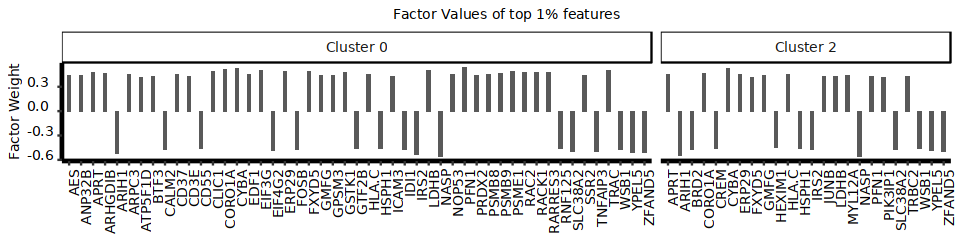

In [510]:
factor_value_all_bar

In [511]:
pdf(paste0('figures/Final_Figures/', figure_name,'bar', factor_var, '_',filtered_samples, '_',  top_frac,  name, train_opts$weight_views, '.pdf'), width =width_par_bar, height =height_par)
print(factor_value_all_bar)
dev.off()

png 
  2

## Violin Plots

In [563]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,delta_ef_value,facet2,tp_outcome_new
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)


In [564]:
select_example_variables = unique(heatmap_data[,c('type.x', 'variable_name')]) %>% group_by(type.x) %>% summarise(variable_name = max(variable_name))
investigate_sample_na = merge(heatmap_data[heatmap_data$variable == 'Factor1',], select_example_variables)

In [565]:
#heatmap_data[heatmap_data$gene == 'CALM1',]

In [566]:
heatmap_data$cluster[is.na(heatmap_data$cluster)] = heatmap_data$view[is.na(heatmap_data$cluster)]

In [567]:
unique(heatmap_data$cluster)

[1] "Proteomics" "Cluster 4"  "Cluster 5"  "Cluster 6"  "Cluster 0" 
 [6] "Neutrophil" "Cluster 7"  "Cluster 1"  "Cluster 10" "Cluster 3" 
[11] "Cluster 11" "Cluster 9"  "Cluster 12" "Cluster 2"  "Cluster 8" 
[16] "Cluster 13" "Cytokine"   "Clinical"

In [568]:
unique(heatmap_data$class)

[1] no_ccs ccs    acs   
Levels: no_ccs acs ccs

In [569]:
unique(heatmap_data$tp_outcome)

[1] TP0_NA   TP1_NA   TP1_bad  TP2_bad  TP3_bad  TP2_NA   TP3_NA   TP4_NA  
 [9] TP4_bad  TP1_good TP2_good TP3_good TP4_good
13 Levels: TP1_good TP2_good TP3_good TP4_good TP1_bad TP2_bad ... TP4_NA

In [570]:
heatmap_data$class = as.factor(heatmap_data$class)
heatmap_data$class = relevel(heatmap_data$class, ref = 'no_ccs')

In [571]:
heatmap_data$tp_outcome = as.factor(heatmap_data$tp_outcome)
heatmap_data$tp_outcome = factor(heatmap_data$tp_outcome, levels = c(
    'TP1_good', 'TP2_good', 'TP3_good', 'TP4_good', 'TP1_bad','TP2_bad',
    'TP3_bad','TP4_bad' , 'TP0_NA', 'TP1_NA' , 'TP2_NA',  'TP3_NA', 'TP4_NA'))

In [572]:
#heatmap_data[(heatmap_data$cluster == 'Proteomics') & !is.na(str_extract(heatmap_data$variable_name, 'CRP')),]

In [573]:
violin_configs = read.csv(paste0(data_path, '/preprocessed-data/meta-data/violin_input.csv'))

In [574]:
nrow(violin_configs)

[1] 51

In [575]:
unique(violin_configs$facet_variable)

[1] "measurement_class" "class"             "tp_outcome"

In [576]:
#violin_configs = violin_configs[violin_configs$factor == 'Factor1',]
#violin_configs = violin_configs[1:1,]

In [577]:
head(violin_configs,2)

,factor,cluster,genes,facet_variable,facet_subset,width,height,p_val_comp
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Factor2,Cytokine,"IL27,IL12A,IL12B,IL10,LIF,IL17A,CXCL12,CX3CL1,TNFS10,CXCL9,CXCL10,CCL24",measurement_class,"TP0_ccs,TP1_acs_w_o_infection,TP2_acs_w_o_infection,TP3_acs_w_o_infection,TP4_acs_w_o_infection",0.5,2,"TP0_ccs,TP1_acs_w_o_infection;TP0_ccs,TP2_acs_w_o_infection"
2,Factor2,Cytokine,"IL27,IL12A,IL12B,IL10",measurement_class,"TP0_ccs,TP1_acs_w_o_infection,TP2_acs_w_o_infection,TP3_acs_w_o_infection,TP4_acs_w_o_infection",0.7,2,"TP0_ccs,TP1_acs_w_o_infection;TP0_ccs,TP2_acs_w_o_infection"


In [578]:
figure_name = "FIG5_Violin_"

In [579]:
# Specific Text Descriptions:
xlabel = xlab('Gene') 
ylabel = ylab('Normalized Gene Expression')

In [580]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,delta_ef_value,facet2,tp_outcome_new
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)


In [581]:
### Empty dataframe to save testing result to
heatmap_data_tests_measurement = data.frame()
heatmap_data_tests_class = data.frame()

In [582]:
for(i in 1:nrow(violin_configs)){
    factor_var = violin_configs$factor[i]
    width_par = violin_configs$width[i]
    height_par = violin_configs$height[i]
    
    view = unique(heatmap_data$cell_type)
    cluster = violin_configs$cluster[i]
    genes = violin_configs$genes[i]
    
    variable = violin_configs$facet_variable[i]
    facet_subset  = violin_configs$facet_subset[i]

    
    # specify faceting and grouping
    heatmap_data$facet2 = heatmap_data[,variable]

    
    # subset data on group
    heatmap_data_plot = heatmap_data[heatmap_data$facet2 %in% unlist(strsplit(facet_subset,",")),]
    
    heatmap_data_plot$facet = paste0(heatmap_data_plot$direction_sign, heatmap_data_plot$cluster)
    
    ## subset based on selected genes and cell-types
    heatmap_data_plot = heatmap_data_plot[heatmap_data_plot$fraction == max(heatmap_data$fraction),]
    heatmap_data_plot = heatmap_data_plot[(heatmap_data_plot$cell_type %in% view) & (heatmap_data_plot$gene %in% unlist(strsplit(genes, ",")))  & (heatmap_data_plot$cluster %in% unlist(strsplit(cluster,","))),]
    
    ## add copy of data for testing
    heatmap_data_testing_all = heatmap_data_plot[heatmap_data_plot$variable == factor_var,]
    
    if(variable == 'measurement_class'){
        
        for(i in unique(heatmap_data_testing_all$variable_name)){
            heatmap_data_testing = heatmap_data_testing_all[heatmap_data_testing_all$variable_name == i,]
            heatmap_data_testing$measurement2 = factor(heatmap_data_testing$measurement2)
            
            res_aov = aov(expression_value ~ measurement2, data = heatmap_data_testing)  # first one way anova
            set.seed(1)
            dunnets = glht(res_aov,linfct = mcp(measurement2 = "Dunnett")) # next Dunnett's test
            
            p_val_dunnet = summary(dunnets)$test$pvalues
            names(p_val_dunnet) = rownames(summary(dunnets)$linfct)
            test_result = data.frame(p_value_anova = summary(res_aov)[[1]][1,5] , t(p_val_dunnet))


            heatmap_data_testing = cbind(heatmap_data_testing, test_result)
            ### save used data
            heatmap_data_tests_measurement = rbind(heatmap_data_tests_measurement, heatmap_data_testing)
                      }
            }
    
    if(variable == 'class'){

    for(i in unique(heatmap_data_testing_all$variable_name)){
        heatmap_data_testing = heatmap_data_testing_all[heatmap_data_testing_all$variable_name == i,]
        heatmap_data_testing$class = factor(heatmap_data_testing$class)

        res_aov = aov(expression_value ~ class, data = heatmap_data_testing)  # first one way anova
        set.seed(1)
        dunnets = glht(res_aov,linfct = mcp(class = "Dunnett")) # next Dunnett's test

        p_val_dunnet = summary(dunnets)$test$pvalues
        names(p_val_dunnet) = rownames(summary(dunnets)$linfct)
        test_result = data.frame(p_value_anova = summary(res_aov)[[1]][1,5] , t(p_val_dunnet))


        heatmap_data_testing = cbind(heatmap_data_testing, test_result)
        ### save used data
        heatmap_data_tests_class = rbind(heatmap_data_tests_class, heatmap_data_testing)
                  }
        }
        
    
    width_par_plot = 0.87 + width_par * length(unique(heatmap_data_plot$variable_name))
    
    ### Without p-values
    violin_plot = ggplot(heatmap_data_plot[heatmap_data_plot$variable == factor_var,], aes(x=gene, y=expression_value, fill = as.factor(facet2))) + 
        geom_violin(trim=FALSE, size = 0.01)+ geom_sina(alpha=1, size = 0.2) +
        facet_grid(~  facet, scales = 'free', space = 'free',  switch = "y") +
        plot_config +
        theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.1, "cm"), axis.title.y = element_blank(), axis.title.x = element_blank(), panel.spacing = unit(0.1, "cm")) + 
        #ggtitle("Normalized Expression values") +
        xlabel +
        ylabel +
        ccs_tp_color2 + theme(legend.position="none")
    
    pdf(paste0('figures/Final_Figures/', figure_name,paste0(genes, collapse = '_'),  name, train_opts$weight_views, '.pdf'), width =  width_par_plot, height =height_par)
    print(violin_plot )
    dev.off()
     
    }

Warning message:
“Removed 24 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 36 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 36 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_sina()`).”
Warning me

## Violin Plots with Time-Course

In [583]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,delta_ef_value,facet2,tp_outcome_new
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.004658554,negative,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.132600594,positive,⋯,vollstaendiger_ausschluss,NA,no_ccs,No CCS,TP0_vollstaendiger_ausschluss,NA,TP0_NA,NA,TP0_NA,TP0 (NA)


In [584]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "delta_ef_value"                 
[25] "facet2"                          "tp_outcome_new"

In [585]:
unique(heatmap_data$cluster)

[1] "Proteomics" "Cluster 4"  "Cluster 5"  "Cluster 6"  "Cluster 0" 
 [6] "Neutrophil" "Cluster 7"  "Cluster 1"  "Cluster 10" "Cluster 3" 
[11] "Cluster 11" "Cluster 9"  "Cluster 12" "Cluster 2"  "Cluster 8" 
[16] "Cluster 13" "Cytokine"   "Clinical"

In [586]:
#heatmap_data[(heatmap_data$cluster == 'Proteomics') & !is.na(str_extract(heatmap_data$variable_name, 'CRP')),]

In [587]:
violin_configs = read.csv(paste0(data_path, '/preprocessed-data/meta-data/violin_input_supp.csv'))

In [588]:
head(violin_configs,2)

,factor,cluster,genes,facet_variable,facet_subset,width,height,p_val_comp
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Factor4,Cluster 3,"PRF1,GZMB,TXNIP",tp_outcome,"TP1_bad,TP1_good,TP2_bad,TP2_good,TP3_bad,TP3_good,TP4_bad,TP4_good",1.7,1.6,"TP1_bad,TP1_good"
2,Factor4,Cluster 3,"CD53,CST7,FYN,LITAF",tp_outcome,"TP1_bad,TP1_good,TP2_bad,TP2_good,TP3_bad,TP3_good,TP4_bad,TP4_good",1.7,1.6,"TP1_bad,TP1_good"


In [589]:
figure_name = "SUPP4_Violin_"

In [590]:
# Specific Text Descriptions:
xlabel = xlab('Gene') 
ylabel = ylab('Normalized Gene Expression')

In [591]:
unique(heatmap_data$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [592]:
unique(heatmap_data$variable_name[(!is.na(str_extract(heatmap_data$gene, 'SERPINA'))) & (heatmap_data$view == 'Proteomics') ])

[1] "SERPINA1_P01009"     "SERPINA5_P05154"     "SERPINA3_G3V3A0"    
 [4] "SERPINA3_P01011"     "SERPINA6_P08185"     "SERPINA7_P05543"    
 [7] "SERPINA4_P29622"     "SERPINA11_Q86U17"    "SERPINA1_A0A024R6I7"
[10] "SERPINA10_G3V2W1"

In [593]:
#head(heatmap_data_plot,2)

In [594]:
for(i in 1:nrow(violin_configs)){
    factor_var = violin_configs$factor[i]
    width_par = violin_configs$width[i]
    height_par = violin_configs$height[i]
    
    view = unique(heatmap_data$cell_type)
    cluster = violin_configs$cluster[i]
    genes = violin_configs$genes[i]
    
    variable = violin_configs$facet_variable[i]
    facet_subset  = violin_configs$facet_subset[i]

    
    # specify faceting and grouping
    heatmap_data$facet2 = heatmap_data[,variable]

    
    # subset data on group
    heatmap_data_plot = heatmap_data[heatmap_data$facet2 %in% unlist(strsplit(facet_subset,",")),]
    
    heatmap_data_plot$facet = paste0(heatmap_data_plot$direction_sign, heatmap_data_plot$cluster)
    
    ## subset based on selected genes and cell-types
    heatmap_data_plot = heatmap_data_plot[heatmap_data_plot$fraction == max(heatmap_data$fraction),]
    heatmap_data_plot = heatmap_data_plot[(heatmap_data_plot$cell_type %in% view) & (heatmap_data_plot$gene %in% unlist(strsplit(genes, ",")))  & (heatmap_data_plot$cluster %in% unlist(strsplit(cluster,","))),]
    
    width_par_plot = 0.87 + width_par * length(unique(heatmap_data_plot$variable_name))
    
    ### Without p-values
    violin_plot = ggplot(heatmap_data_plot[heatmap_data_plot$variable == factor_var,], aes(x=measurement, y=expression_value, fill = as.factor(facet2))) + 
        geom_violin(trim=FALSE, size = 0.01) + geom_sina(alpha=1, size = 0.05) +
        facet_grid(facet~  gene, scales = 'free', space = 'free',  switch = "y") +
        plot_config +
        theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.1, "cm"), axis.title.y = element_blank(), axis.title.x = element_blank(), panel.spacing = unit(0.1, "cm")) + 
        #ggtitle("Normalized Expression values") +
        xlabel +
        ylabel +
        ccs_tp_color2 + theme(legend.position="none")
    
    pdf(paste0('figures/Supplementary_Figures/', figure_name,paste0(genes, collapse = '_'),  name, train_opts$weight_views, '.pdf'), width =  width_par_plot, height =height_par)
    print(violin_plot )
    dev.off()
    
    
    }

Warning message:
“Removed 18 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 24 rows containing non-finite values (`stat_sina()`).”
